<b><font color="SteelBlue" size="+3">Anticipez les besoins en consommation de bâtiments</font></b>

# Introduction

## Contexte

Le projet se situe dans le cadre des efforts de la ville de Seattle pour atteindre son objectif de neutralité carbone d'ici 2050, un enjeu majeur dans la lutte contre le changement climatique. L'accent est mis sur l'analyse de la consommation énergétique et des émissions de dioxyde de carbone (CO2) des bâtiments non résidentiels, une composante significative de l'empreinte carbone de la ville. Pour cela, la ville dispose de données collectées en 2016, reflétant les consommations et émissions des bâtiments à cette période. Ces données, bien que précieuses, sont coûteuses et laborieuses à obtenir, d'où l'intérêt de développer un modèle prédictif capable d'estimer ces indicateurs pour les bâtiments non encore analysés, basé sur des caractéristiques structurelles telles que la taille, l'usage, la date de construction, ou encore la situation géographique des bâtiments.

## Objectifs

Tout d'abvord, réaliser une analyse exploratoire des données disponibles afin d'identifier les tendances, les anomalies et les relations potentielles entre les différentes variables. Et ensuite tester et comparer différents modèles de machine learning pour prédire avec précision la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, sans données de consommation annuelle future, pour éviter toute fuite de données. Un intérêt particulier est porté à l'évaluation de l'utilité de l'"ENERGY STAR Score", un indicateur potentiellement pertinent mais complexe à calculer avec les méthodes actuelles. 

## Imports

In [1]:
# Chargement des librairies
# Builtin
import os

# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from IPython.display import Image

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_exploratoire_022024.ipynb',
 'Deveau_Estelle_2_notebook_prediction_022024.ipynb',
 'Map_of_Seattle,_divided_by_districts.png',
 'svg']

In [3]:
os.listdir("data/sources/")

['2016_Building_Energy_Benchmarking.csv']

In [4]:
path     = "./data/sources/"
filename = "2016_Building_Energy_Benchmarking.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploration des données

## Quick tour

In [7]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

In [8]:
data.shape

(3376, 46)

In [9]:
data.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
Name: count, dtype: int64

In [10]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3376.000000      3.376000e+03         3376.000000   
mean         4.709123      9.483354e+04         8001.526066   
std          5.494465      2.188376e+05        32326.723928   
min          0.000000      1.128500e+04            0.000000   
25%          2.000000      2.848700e+04            0.000000   
50%          4.000000      4.417500e+04            0.000000   
75%          5.000000      9.099200e+04            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.376000e+03               3.356000e+03   
mean             8.683201e+04               7.917764e+04   
std              2.079398e+05               2.017034e+05   
min              3.636000e+03               5.656000e+03   
25%              2.775600e+04               2.509475e+04   
50%              4.321600e+04               3.989400e+04   
75%              8.427625e+04               7.620025e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1679.000000                      596.000000   
mean                      28444.075817                    11738.675166   
std                       54392.917928                    29331.199286   
min                           0.000000                        0.000000   
25%                        5000.000000                     2239.000000   
50%                       10664.000000                     5043.000000   
75%                       26640.000000                    10138.750000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count      2533.000000       3369.000000         3370.000000   
mean         67.918674         54.732116           57.033798   
std          26.873271         56.273124           57.163330   
min           1.000000          0.000000            0.000000   
25%          53.000000         27.900000           29.400000   
50%          75.000000         38.599998           40.900002   
75%          90.000000         60.400002           64.275002   
max         100.000000        834.400024          834.400024   

       SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
count         3367.000000           3367.000000         3.371000e+03   
mean           134.232848            137.783932         5.403667e+06   
std            139.287554            139.109807         2.161063e+07   
min              0.000000             -2.100000         0.000000e+00   
25%             74.699997             78.400002         9.251286e+05

In [11]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.85 %


In [13]:
percent_missing_values =  round((missing_values_count / len(data)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
OSEBuildingID                                               0   
DataYear                                                    0   
BuildingType                                                0   
PrimaryPropertyType                                         0   
PropertyName                                                0   
Address                                                     0   
City                                                        0   
State                                                       0   
ZipCode                                                    16   
TaxParcelIdentificationNumber                               0   
CouncilDistrictCode                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
YearBuilt                                                   0   
NumberofBuildings                                           8   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
PropertyGFABuilding(s)                                      0   
ListOfAllPropertyUseTypes                                   9   
LargestPropertyUseType                                     20   
LargestPropertyUseTypeGFA                                  20   
SecondLargestPropertyUseType                             1697   
SecondLargestPropertyUseTypeGFA                          1697   
ThirdLargestPropertyUseType                              2780   
ThirdLargestPropertyUseTypeGFA                           2780   
YearsENERGYSTARCertified                                 3257   
ENERGYSTARScore                                           843   
SiteEUI(kBtu/sf)                                            7   
SiteEUIWN(kBtu/sf)                                          6   
SourceEUI(kBtu/sf)                                          9   
SourceEUIWN(kBtu/sf)                                        9   
SiteEnergyUse(kBtu)                                         5   
SiteEnergyUseWN(kBtu)                                       6   
SteamUse(kBtu)                                              9   
Electricity(kWh)                                            9   
Electricity(kBtu)                                           9   
NaturalGas(therms)                                          9   
NaturalGas(kBtu)                                            9   
DefaultData                                                 0   
Comments                                                 3376   
ComplianceStatus                                            0   
Outlier                                                  3344   
TotalGHGEmissions                                           9   
GHGEmissionsIntensity                                       9   

                                 Pourcentage de valeurs manquantes  
OSEBuildingID                                                 0.00  
DataYear                                                      0.00  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
PropertyName                                                  0.00  
Address                                                       0.00  
City                                                          0.00  
State                                                         0.00  
ZipCode                                                       0.47  
TaxParcelIdentificationNumber                                 0.00  
CouncilDistrictCode                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude  

<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

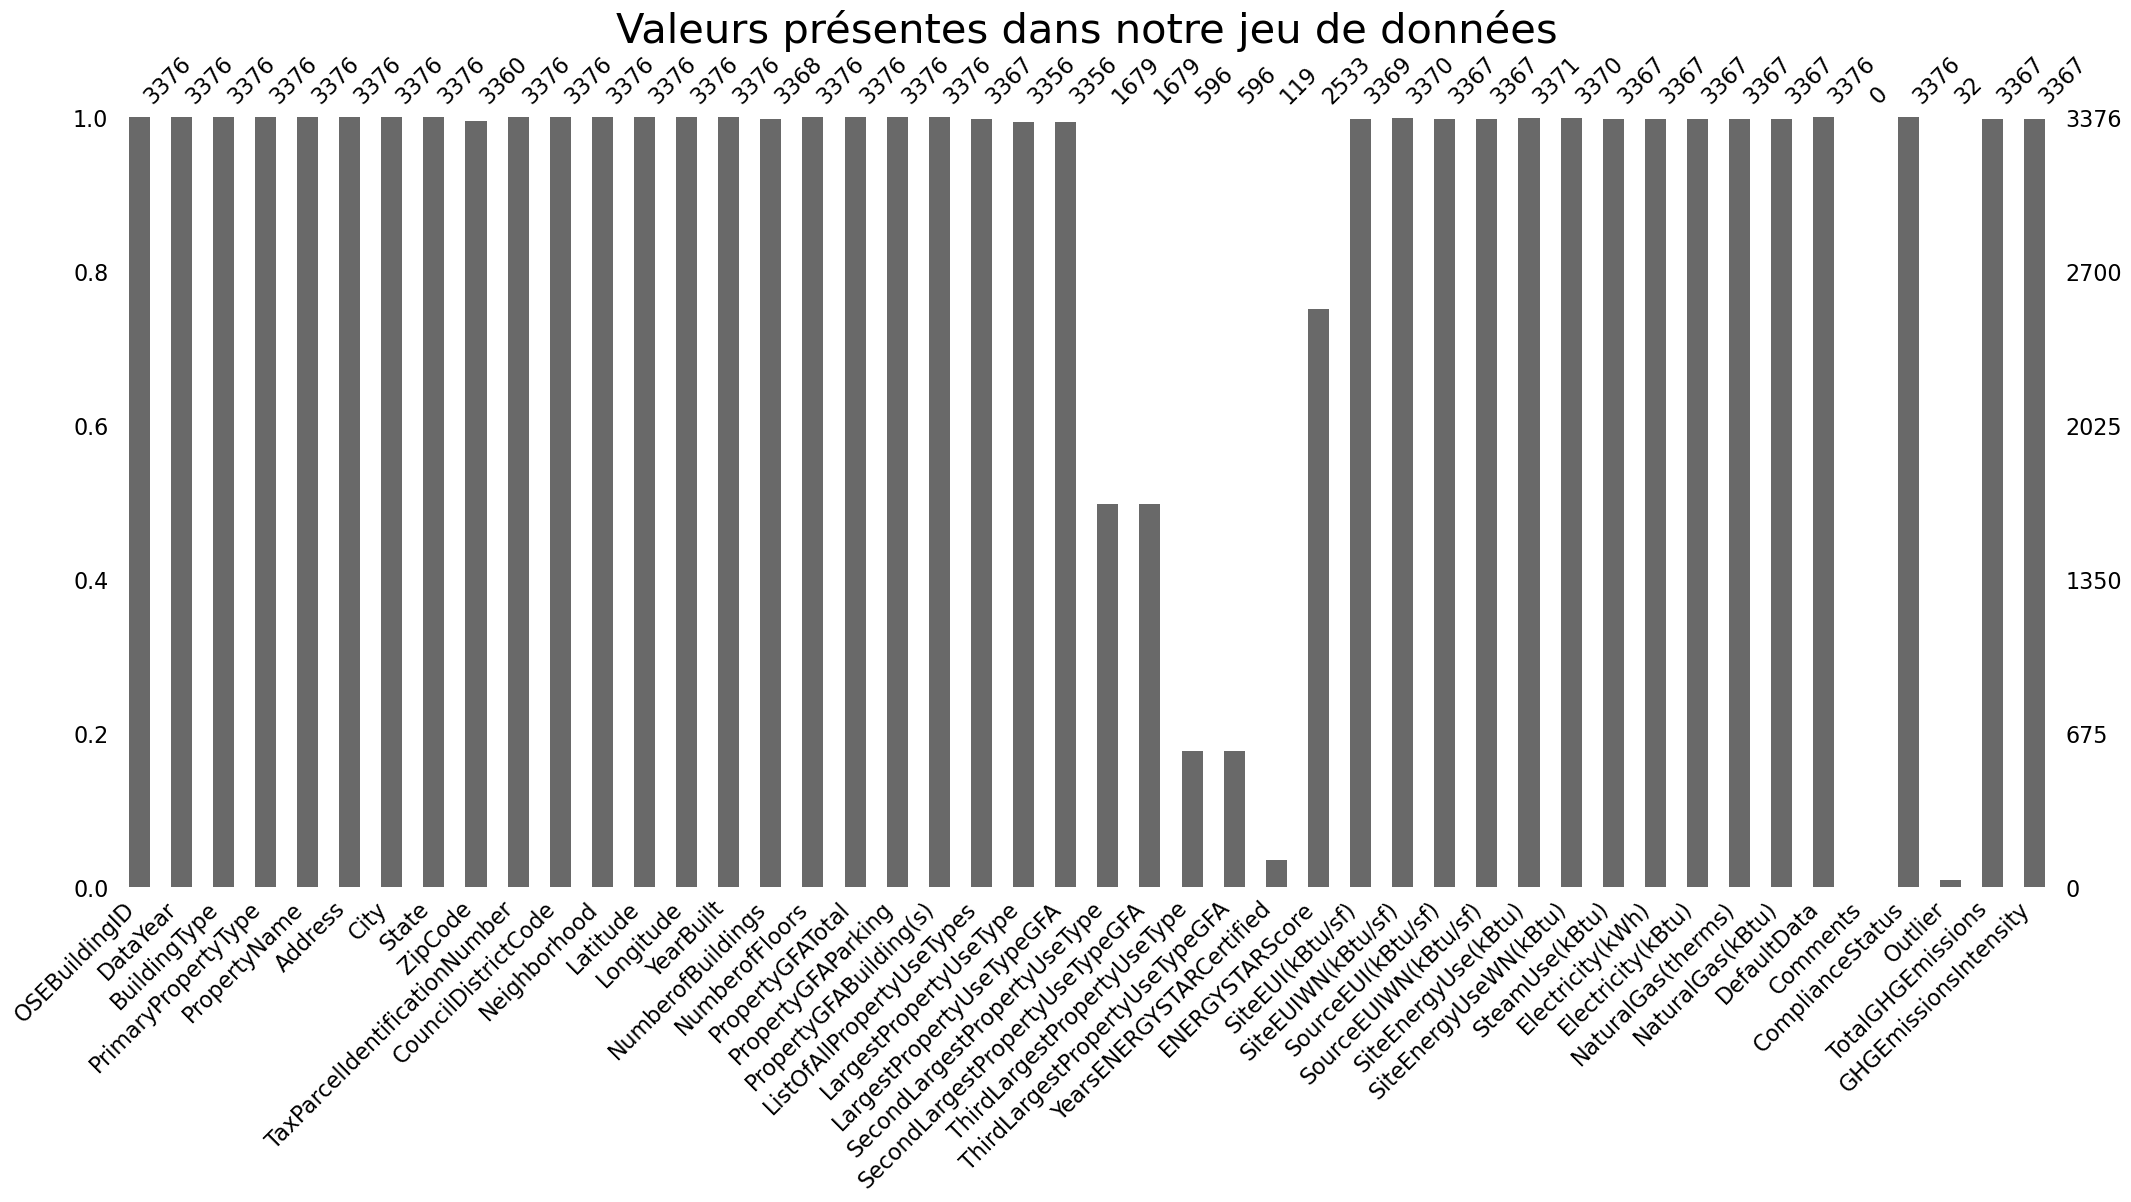

In [14]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(data)

<Axes: >

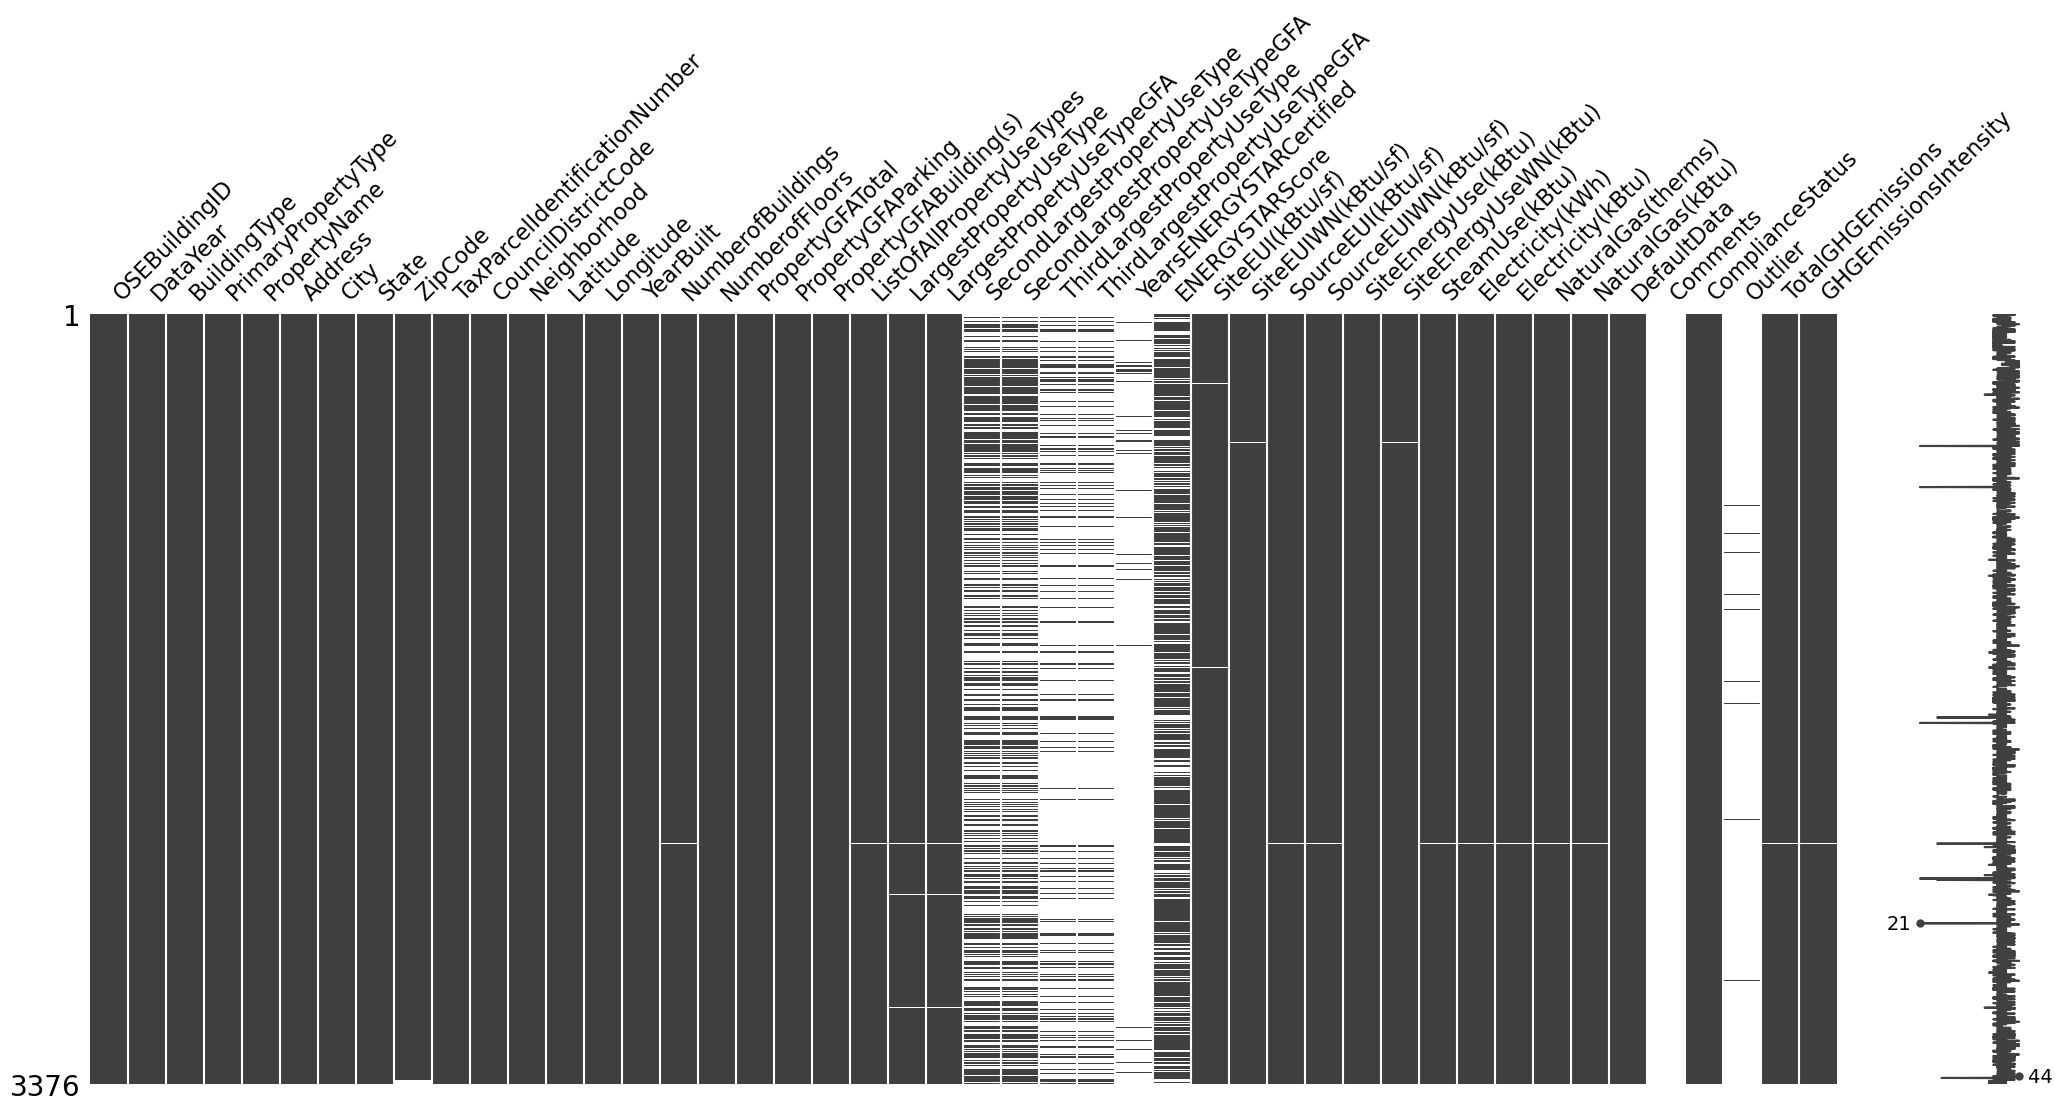

In [15]:
msno.matrix(data)

<Axes: >

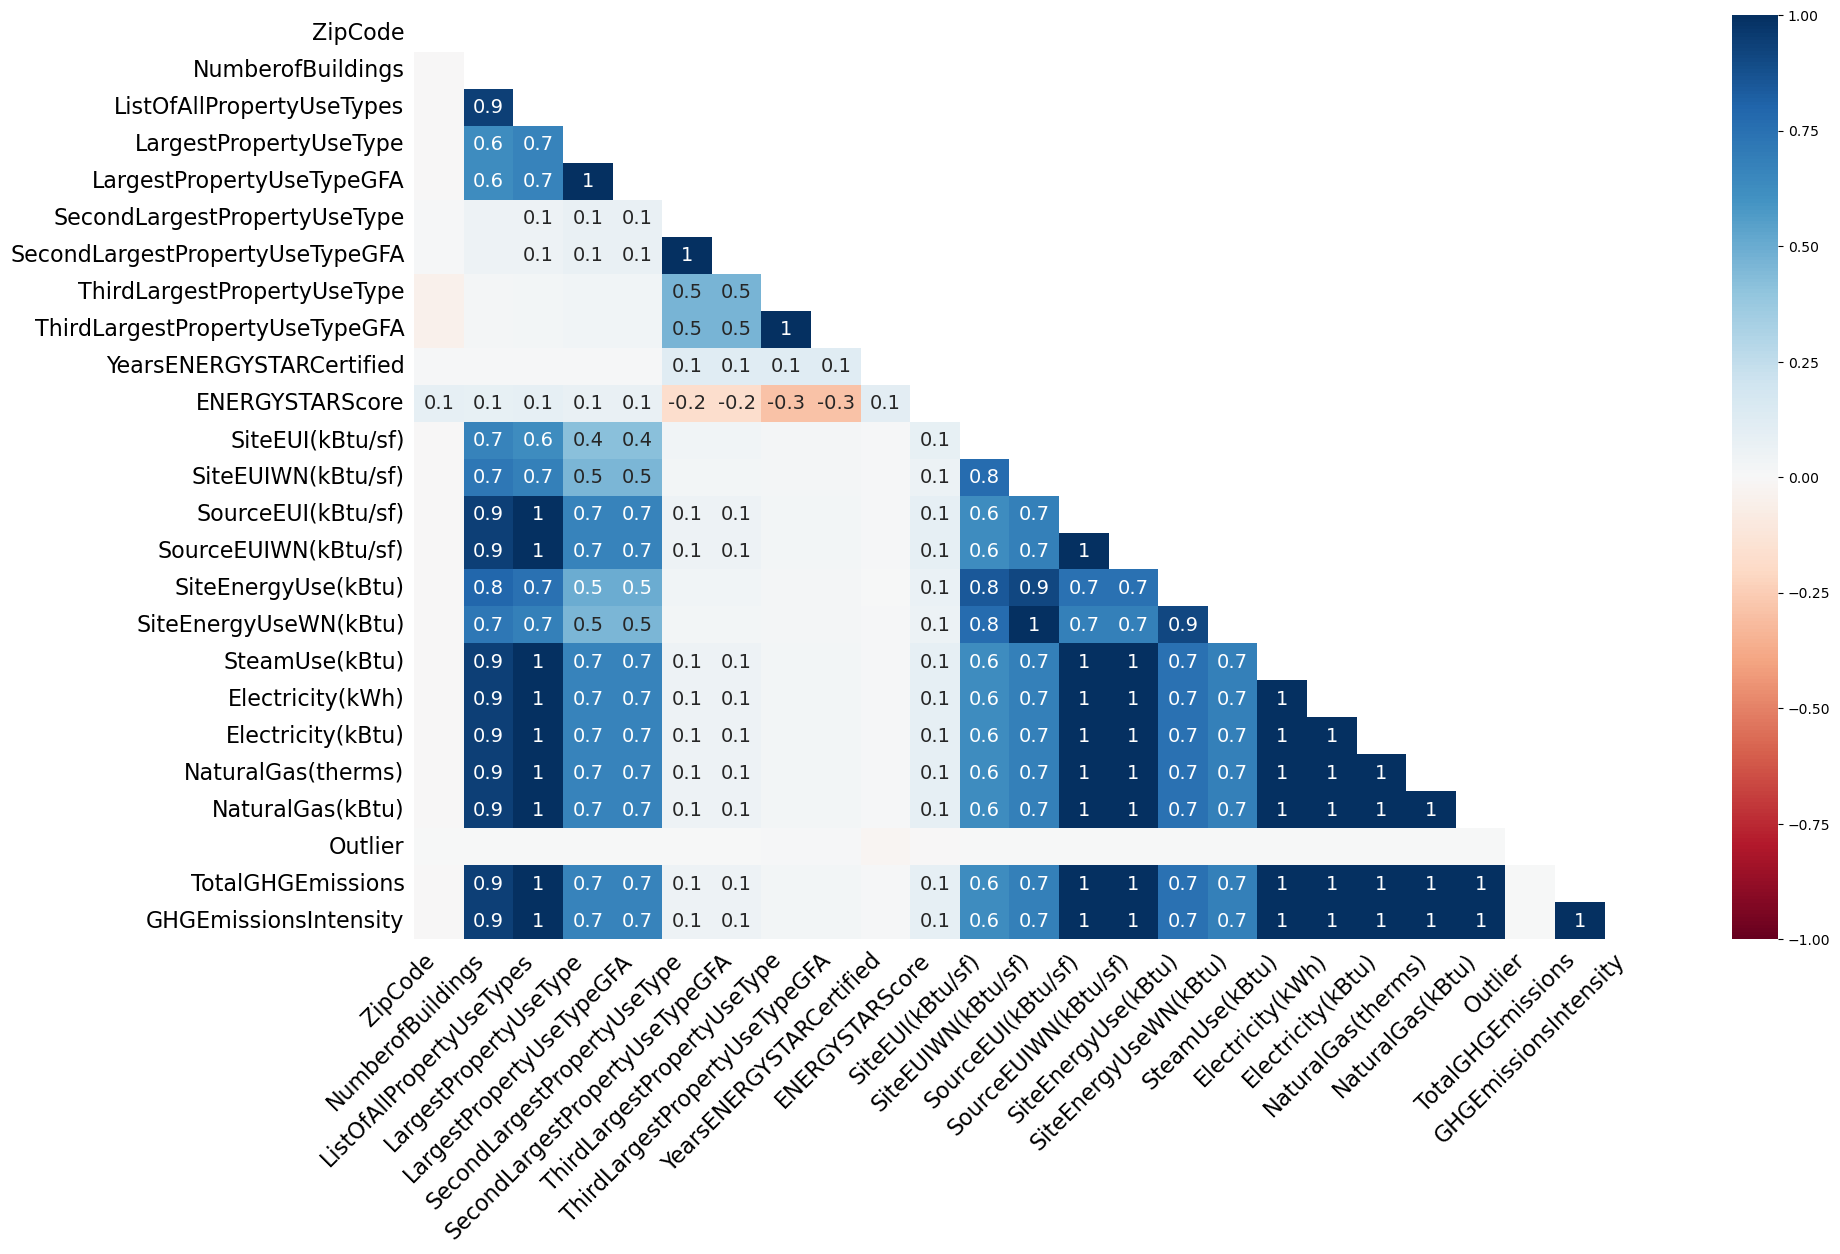

In [16]:
msno.heatmap(data)

## Définition et Compréhension des Variables

Après examen de la liste des variables et de leur définitions (https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy/about_data), nous avons établi la liste suivante :


| Name                          | Definition                                                                                     | Useful | Note |
|-------------------------------|------------------------------------------------------------------------------------------------|--------|------|
| OSEBuildingID                 | Identifiant unique attribué à chaque propriété couverte par l'ordonnance de référencement de Seattle. | Oui    | Essentiel pour suivre et identifier les propriétés |
| DataYear                      | Année civile représentée par chaque enregistrement de données.                                  | Non    |      |
| BuildingType                  | Classification du type de bâtiment de la ville de Seattle.                                     | Oui    | Utile pour des analyses par type de bâtiment |
| PrimaryPropertyType           | Utilisation principale d'une propriété (ex : bureau, magasin de détail).                        | Oui    | Utile pour des analyses par type d'utilisation |
| PropertyName                  | Nom officiel ou courant de la propriété.                                                        | Non    |      |
| Address                       | Adresse de la propriété.                                                                        | Oui    | Utile pour verifier les outliers |
| City                       | Ville de la propriété.                                                                        | Non    |      |
| State                       | Etat de la propriété.                                                                        | Non    |      |
| ZipCode                       | Code postal de la propriété.                                                                    | Non    | On utilisera les quartiers |
| TaxParcelIdentificationNumber | Numéro d'identification de la parcelle fiscale de la propriété.                                 | Non    |      |
| CouncilDistrictCode           | Code du district du conseil de la ville de Seattle de la propriété.                             | Non    | On utilisera les quartiers |
| Neighborhood                  | Quartier de la propriété défini par le département des quartiers de la ville de Seattle.         | Oui    | Utile pour des analyses géographiques |
| Latitude                      | Latitude de la propriété.                                                                       | Oui    | Essentiel pour des analyses géospatiales |
| Longitude                     | Longitude de la propriété.                                                                      | Oui    | Essentiel pour des analyses géospatiales |
| YearBuilt                     | Année de construction de la propriété.                                                          | Oui    | Utile pour des analyses liées à l'âge du bâtiment |
| NumberofBuildings             | Nombre de bâtiments inclus dans le rapport de la propriété.                                     | Oui    | Utile pour des analyses de taille et de complexité |
| NumberofFloors                | Nombre d'étages signalés dans Portfolio Manager.                                                 | Oui    | Utile pour des analyses de taille et de complexité |
| PropertyGFATotal              | Surface brute totale du bâtiment et du parking.                                                 | Oui    | Utile pour des analyses de taille |
| PropertyGFAParking            | Espace total en pieds carrés de tous les types de stationnement.                                | Oui    | Utile pour des analyses de taille |
| PropertyGFABuilding(s)        | Surface brute totale en pieds carrés entre les surfaces extérieures des murs d'enceinte du bâtiment. | Oui    | Utile pour des analyses de taille |
| ListOfAllPropertyUseTypes     | Toutes les utilisations de la propriété                        | Oui    | Utile pour compter le nombre d'utilisations |
| LargestPropertyUseType        | La plus grande utilisation de la propriété par la surface brute.                                | Oui    | Utile pour des analyses par type d'utilisation |
| LargestPropertyUseTypeGFA     | Surface brute de la plus grande utilisation de la propriété.                                    | Oui    | Utile pour des analyses par type d'utilisation |
| SecondLargestPropertyUseType  | La deuxième plus grande utilisation de la propriété par la surface brute.                        | Oui    | Utile pour des analyses par type d'utilisation |
| SecondLargestPropertyUseTypeGFA | Surface brute de la deuxième plus grande utilisation de la propriété.                          | Oui    | Utile pour des analyses par type d'utilisation |
| ThirdLargestPropertyUseType   | La troisième plus grande utilisation de la propriété par la surface brute.                       | Oui    | Utile pour des analyses par type d'utilisation |
| ThirdLargestPropertyUseTypeGFA| Surface brute de la troisième plus grande utilisation de la propriété.                          | Oui    | Utile pour des analyses par type d'utilisation |
| YearsENERGYSTARCertified      | Années où la propriété a reçu la certification ENERGY STAR.                                     | Non    |      |
| ENERGYSTARScore               | Score calculé pour évaluer la performance énergétique globale de la propriété.               | Oui    | Objectif |
| SiteEUI(kBtu/sf)              | Intensité d'utilisation de l'énergie sur site (EUI) de la propriété.                            | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEUIWN(kBtu/sf)            | EUI du site normalisée (WN) de la propriété.                                  | Oui    | Fuite des données mais utile pour des vérifications |
| SourceEUI(kBtu/sf)            | Intensité d'utilisation de l'énergie source (EUI) de la propriété.                              | Oui    | Fuite des données mais utile pour des vérifications |
| SourceEUIWN(kBtu/sf)          | EUI de l'énergie source normalisée (WN) de la propriété.                            | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEnergyUse(kBtu)           | Quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie. | Oui    | Fuite des données mais utile pour des vérifications |
| SiteEnergyUseWN(kBtu)         | Quantité annuelle d'énergie consommée par la propriété, ajustée aux conditions météorologiques moyennes sur 30 ans. | Oui | Objectif |
| SteamUse(kBtu)                | Quantité annuelle de vapeur de district consommée par la propriété sur place.                    | Oui    | Fuite des données mais peut indiquer la nature de la source d'energie |
| Electricity(kWh)              | Quantité annuelle d'électricité consommée par la propriété sur place.                            | Oui    | Fuite des données mais utile pour des vérifications |
| Electricity(kBtu)             | Quantité annuelle d'électricité consommée par la propriété sur place, mesurée en milliers de BTU. | Oui    | Fuite des données mais peut indiquer la nature de la source d'energie |
| NaturalGas(therms)            | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété.     | Oui    | Fuite des données mais utile pour des vérifications |
| NaturalGas(kBtu)              | Quantité annuelle de gaz naturel fourni par les services publics consommée par la propriété, mesurée en milliers de BTU. | Oui | Fuite des données mais peut indiquer la nature de la source d'energie |
| DefaultData                   | La propriété a utilisé des données par défaut pour au moins une caractéristique de la propriété.  | Non    |      |
| Comments                      | Commentaires d'un propriétaire ou d'un agent pour fournir un contexte à l'utilisation de l'énergie du bâtiment. | Non  |      |
| ComplianceStatus              | Si une propriété a respecté les exigences de référencement énergétique pour l'année de déclaration en cours. | Oui  |      |
| Outlier                       | Si une propriété est un cas extrême élevé ou faible (O/N).                                       | Oui    |      |
| TotalGHGEmissions             | Quantité totale d'émissions de gaz à effet de serre.                                             | Oui    | Objectif |
| GHGEmissionsIntensity         | Émissions totales de gaz à effet de serre divisées par la surface brute de la propriété.         | Oui    | Fuite des données mais utile pour des vérifications |

In [17]:
cols_to_drop = ['DataYear', 'City', 'State', 'ZipCode', 'CouncilDistrictCode', 'PropertyName','TaxParcelIdentificationNumber', 
                'YearsENERGYSTARCertified', 'DefaultData','Comments']

# Liste de toutes les colonnes à conserver
cols_to_keep = data.columns.difference(cols_to_drop)

# Nettoyage des Données

## Format des données

In [18]:
data[cols_to_keep].dtypes

Address                             object
BuildingType                        object
ComplianceStatus                    object
ENERGYSTARScore                    float64
Electricity(kBtu)                  float64
Electricity(kWh)                   float64
GHGEmissionsIntensity              float64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
ListOfAllPropertyUseTypes           object
Longitude                          float64
NaturalGas(kBtu)                   float64
NaturalGas(therms)                 float64
Neighborhood                        object
NumberofBuildings                  float64
NumberofFloors                       int64
OSEBuildingID                        int64
Outlier                             object
PrimaryPropertyType                 object
PropertyGFABuilding(s)               int64
PropertyGFAParking                   int64
PropertyGFATotal                     int64
SecondLarge

In [19]:
# Verification des années
print("Valeurs uniques pour YearBuilt dans data:", data['YearBuilt'].unique())

Valeurs uniques pour YearBuilt dans data: [1927 1996 1969 1926 1980 1999 1904 1910 1998 1928 1922 2004 1930 1983
 1907 1916 1985 1961 2001 1991 1955 1978 1949 1989 1906 1994 1992 1990
 1950 1900 1954 1911 1973 1920 1982 1908 1959 2000 1997 1962 1970 2008
 1948 1965 1929 2010 1938 1986 2002 1923 2003 1957 1964 1941 1963 2006
 1915 1958 2009 2011 1971 2007 1951 1953 1952 1960 1937 1966 1968 1925
 1924 2005 1909 1931 1972 1914 1913 1917 1995 1981 1976 1988 1979 1947
 1984 1956 1912 1977 1921 1945 1974 1975 1946 1967 1987 1940 1932 1993
 1918 1905 1902 1939 1944 1942 1903 2012 2013 2015 1901 1919 2014 1936
 1935]


Le format de l'année dans YearBuilt est en int mais ce n'est pas génant donc nous le laissons ainsi et remplaçons cette colonne par l'âge du batiment.

In [20]:
# Calculer l'âge des bâtiments et créer la colonne 'BuildingAge'
data['BuildingAge'] = 2016 - data['YearBuilt']

# Supprimer la colonne 'YearBuilt'
data.drop(columns=['YearBuilt'], inplace=True)

In [21]:
# Verification des BuildingType
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [22]:
# Verification des ComplianceStatus
print("Valeurs uniques pour ComplianceStatus dans data:", data['ComplianceStatus'].unique())

Valeurs uniques pour ComplianceStatus dans data: ['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']


In [23]:
print(data['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: count, dtype: int64


In [24]:
print("Valeurs uniques pour Outlier dans data:", data['Outlier'].unique())

Valeurs uniques pour Outlier dans data: [nan 'High outlier' 'Low outlier']


In [25]:
# Verification des Neighborhood 
print("Valeurs uniques pour Neighborhood dans data:", data['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'Central' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'CENTRAL' 'SOUTHWEST' 'DELRIDGE' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']


In [26]:
# Corrections
data['Neighborhood'] = data['Neighborhood'].str.upper()
data['Neighborhood'] = data['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print("Valeurs uniques pour Neighborhood dans data:", data['Neighborhood'].unique())

Valeurs uniques pour Neighborhood dans data: ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE']


In [27]:
# Vérification des BuildingType
print("Valeurs uniques pour BuildingType dans data:", data['BuildingType'].unique())

Valeurs uniques pour BuildingType dans data: ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']


In [28]:
# Vérification des LargestPropertyUseType
print("Valeurs uniques pour LargestPropertyUseType dans data:", data['LargestPropertyUseType'].unique())

Valeurs uniques pour LargestPropertyUseType dans data: ['Hotel' 'Police Station' 'Other - Entertainment/Public Assembly'
 'Multifamily Housing' 'Library' 'Fitness Center/Health Club/Gym'
 'Social/Meeting Hall' 'Courthouse' 'Other' 'K-12 School'
 'College/University' 'Automobile Dealership' 'Office'
 'Self-Storage Facility' 'Non-Refrigerated Warehouse' 'Other - Mall'
 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital (General Medical & Surgical)' 'Museum'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Other - Lodging/Residential' 'Residence Hall/Dormitory'
 'Other/Specialty Hospital' 'Financial Office' 'Distribution Center'
 'Parking' 'Worship Facility' 'Restaurant' 'Data Center' 'Laboratory'
 'Supermarket/Grocery Store' 'Convention Center'
 'Urgent Care/Clinic/Other Outpatient' nan 'Other - Services' 'Strip Mall'
 'Wholesale Club/Supercenter' 'Refrigerated Warehouse'
 'Manufacturing/Industrial Plant' 'Other - Recreation' 'Lifestyle Center'
 'Other - Public Servic

In [29]:
# Vérification des SecondLargestPropertyUseType
print("Valeurs uniques pour SecondLargestPropertyUseType dans data:", data['SecondLargestPropertyUseType'].unique())

Valeurs uniques pour SecondLargestPropertyUseType dans data: [nan 'Parking' 'Office' 'Restaurant' 'K-12 School' 'Laboratory'
 'Refrigerated Warehouse' 'Non-Refrigerated Warehouse' 'Other - Education'
 'Vocational School' 'Retail Store'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Entertainment/Public Assembly' 'Data Center' 'Swimming Pool'
 'Other' 'Courthouse' 'Residence Hall/Dormitory' 'Distribution Center'
 'Self-Storage Facility' 'Other - Services' 'Movie Theater'
 'Supermarket/Grocery Store' 'Medical Office' 'Other - Recreation'
 'Convenience Store without Gas Station' 'Performing Arts'
 'College/University' 'Other - Restaurant/Bar' 'Adult Education'
 'Enclosed Mall' 'Multifamily Housing' 'Bar/Nightclub' 'Financial Office'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Manufacturing/Industrial Plant' 'Other - Lodging/Residential'
 'Bank Branch' 'Food Service' 'Worship Facility' 'Senior Care Community'
 'Fitness Center/Health Club/Gym' 'Hotel' 'Food Sales

In [30]:
# Vérification des ThirdLargestPropertyUseType
print("Valeurs uniques pour ThirdLargestPropertyUseType dans data:", data['ThirdLargestPropertyUseType'].unique())

Valeurs uniques pour ThirdLargestPropertyUseType dans data: [nan 'Restaurant' 'Swimming Pool' 'Data Center' 'Office' 'Retail Store'
 'Other - Entertainment/Public Assembly' 'Non-Refrigerated Warehouse'
 'Other' 'Distribution Center' 'Food Service' 'Other - Services'
 'Medical Office' 'Parking' 'Other - Utility'
 'Other - Lodging/Residential' 'K-12 School'
 'Fitness Center/Health Club/Gym' 'Social/Meeting Hall'
 'Pre-school/Daycare' 'Convenience Store without Gas Station'
 'Financial Office' 'Other - Restaurant/Bar' 'Other - Education'
 'Multifamily Housing' 'Laboratory' 'Bank Branch' 'Hotel'
 'Personal Services (Health/Beauty, Dry Cleaning, etc)'
 'Other - Recreation' 'Self-Storage Facility' 'Other - Technology/Science'
 'Refrigerated Warehouse' 'Fast Food Restaurant' 'Bar/Nightclub'
 'Manufacturing/Industrial Plant' 'Food Sales' 'Supermarket/Grocery Store'
 'Other/Specialty Hospital' 'Worship Facility' 'Strip Mall'
 'Residence Hall/Dormitory' 'Vocational School' 'College/University'
 

In [31]:
# Vérification des PrimaryPropertyType
print("Valeurs uniques pour PrimaryPropertyType dans data:", data['PrimaryPropertyType'].unique())

Valeurs uniques pour PrimaryPropertyType dans data: ['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'University' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Warehouse' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Low-Rise Multifamily' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant'
 'High-Rise Multifamily' 'Office']


Pas de problèmes sur le format des données des 'use Type'

## Sélection des données

Suppression des variables que nous n'avons pas trouvé pertinantes pour l'étude.

In [32]:
df_filtered = data.drop(columns=cols_to_drop).copy()

Notre étude porte uniquement sur les bâtiments non résidentiel, donc nous supprimons les bâtiments non concernés.

In [33]:
# Selection des batiments résidentiels
df_filtered = df_filtered[~df_filtered['BuildingType'].str.contains("Multifamily", na=False)].copy()
df_filtered = df_filtered[~df_filtered['PrimaryPropertyType'].str.contains("Multifamily", na=False)].copy()
df_filtered = df_filtered[~df_filtered['PrimaryPropertyType'].str.contains("Residence Hall", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Residence Hall/Dormitory", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Lodging", na=False)].copy()
df_filtered = df_filtered[~df_filtered['LargestPropertyUseType'].str.contains("Multifamily", na=False)].copy()

In [34]:
df_filtered.shape

(1629, 36)

## Recherche des doublons

In [35]:
nb_doublons_code = df_filtered.duplicated(subset=["OSEBuildingID"]).sum()
print('Nombre de doublons sur le OSEBuildingID :', nb_doublons_code)

Nombre de doublons sur le OSEBuildingID : 0


In [36]:
nb_doublons_add = df_filtered.duplicated(subset=['Address','PropertyGFATotal']).sum()
print('Nombre de doublons sur l\'adresse :', nb_doublons_add)

Nombre de doublons sur l'adresse : 1


In [37]:
print(data[data.duplicated(['Address','PropertyGFATotal'], keep=False)].sort_values('Address'))

     OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
348            490      2016  NonResidential  Small- and Mid-Sized Office   
349            491      2016  NonResidential  Small- and Mid-Sized Office   

    PropertyName            Address     City State  ZipCode  \
348  North Tower  100 West Harrison  Seattle    WA  98119.0   
349  South Tower  100 West Harrison  Seattle    WA  98119.0   

    TaxParcelIdentificationNumber  CouncilDistrictCode           Neighborhood  \
348                    1989200720                    7  MAGNOLIA / QUEEN ANNE   
349                    1989200740                    7  MAGNOLIA / QUEEN ANNE   

     Latitude  Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
348  47.62224  -122.3585                1.0               5             87178   
349  47.62224  -122.3585                1.0               5             87178   

     PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
348          

Ce sont bien deux bâtiments différents (Tour nord et tour sud) donc  il n'y a pas de doublons.

## Gestion des valeurs aberrantes

In [38]:
df_filtered.dtypes.value_counts()

float64    20
object     10
int64       6
Name: count, dtype: int64

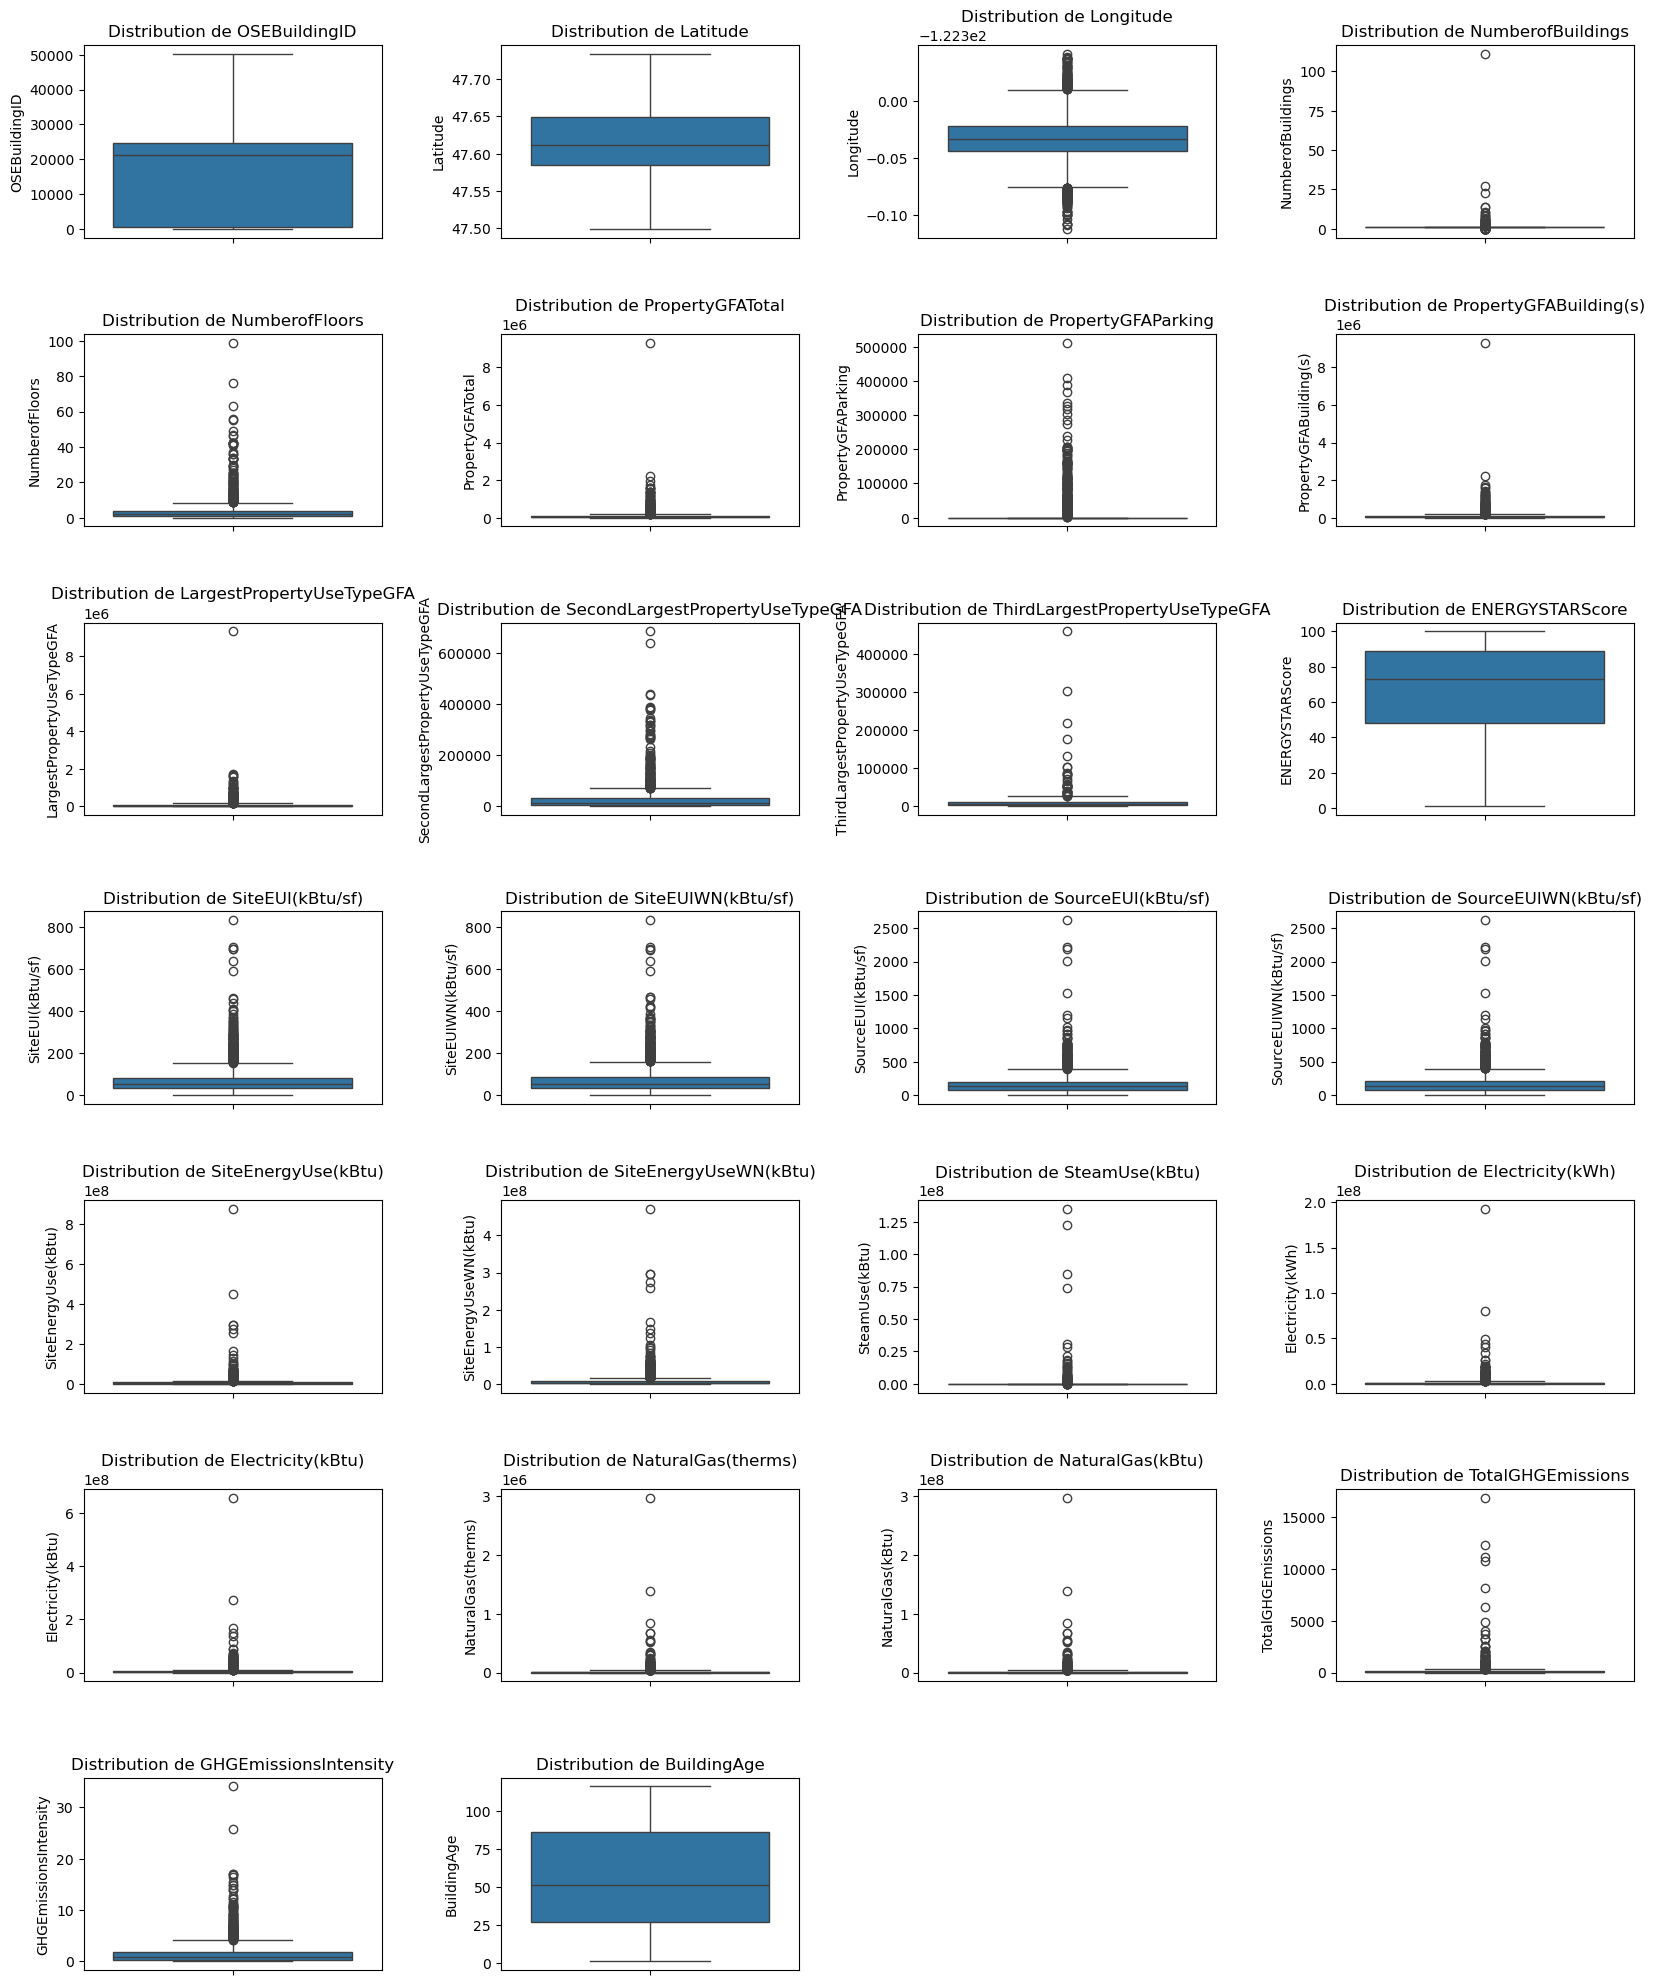

In [39]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df_filtered.select_dtypes(include=['number']).columns
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20,25))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df_filtered[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 28):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [40]:
def find_outliers_by_group(df, groupby_var, outlier_var, iqr_multiplier):
    # Calculer les limites de l'IQR pour chaque groupe
    q1 = df.groupby(groupby_var)[outlier_var].quantile(0.25)
    q3 = df.groupby(groupby_var)[outlier_var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Initialiser une liste pour stocker les DataFrame des outliers
    outliers_list = []

    # Identifier les outliers pour chaque groupe
    for group in df[groupby_var].dropna().unique():
        lower_bound_group = lower_bound.get(group, np.nan)
        upper_bound_group = upper_bound.get(group, np.nan)
        # Utiliser les valeurs obtenues pour filtrer les outliers, en vérifiant aussi que les bornes ne sont pas NaN
        if not np.isnan(lower_bound_group) and not np.isnan(upper_bound_group):
            outliers_group = df[(df[groupby_var] == group) & 
                                ((df[outlier_var] < lower_bound_group) | 
                                 (df[outlier_var] > upper_bound_group))]
            if not outliers_group.empty:
                outliers_list.append(outliers_group)

    # Concaténer les DataFrame des outliers, en vérifiant d'abord si la liste n'est pas vide
    if outliers_list:
        outliers = pd.concat(outliers_list, ignore_index=True)
        return outliers
    else:
        return pd.DataFrame()  # Retourner un DataFrame vide si aucun outlier n'est trouvé



### Vérification de la longitude

Seattle :

    Longitude minimale : aux alentours de -122.436 (ouest)
    Longitude maximale : aux alentours de -122.255 (est)

In [41]:
# Définir les limites de longitude pour Seattle
longitude_min = -122.436
longitude_max = -122.255

# Sélectionner les lignes en dehors de cette fourchette de longitude
outliers_longitude = df_filtered[(df_filtered['Longitude'] < longitude_min) | (df_filtered['Longitude'] > longitude_max)]

# Afficher les valeurs aberrantes
outliers_longitude[['Address', 'Neighborhood', 'Latitude', 'Longitude']]

Empty DataFrame
Columns: [Address, Neighborhood, Latitude, Longitude]
Index: []

Les valeurs sont donc atypiques mais pas abérrantes géographiquement parlant.

### Vérification des NumberofBuildings

In [42]:
# Compter et trier le nombre de valeurs
NumberofBuildings_counts = df_filtered['NumberofBuildings'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofBuildings': NumberofBuildings_counts})

NumberofBuildings
NumberofBuildings                   
111.0                              1
27.0                               1
23.0                               1
14.0                               2
11.0                               1
10.0                               1
9.0                                1
8.0                                2
7.0                                1
6.0                                4
5.0                                7
4.0                                4
3.0                               12
2.0                               14
1.0                             1525
0.0                               50

Il y a forcément au moins 1 bâtiment par adresse, la valeur la plus fréquente étant 1 on remplace les 0 par 1

In [43]:
df_filtered.loc[df_filtered['NumberofBuildings'] == 0.] = 1.

Les adresses avec plus de 7 bâtiments sont à vérifier.

In [44]:
# Sélectionner les lignes où le nombre de bâtiments est supérieur à 10
buildings_over_10 = df_filtered[df_filtered['NumberofBuildings'] > 10]
buildings_over_10[['Address', 'NumberofBuildings', 'PrimaryPropertyType']]

Address  NumberofBuildings PrimaryPropertyType
105             6000 16th Ave SW               27.0          University
128           9600 COLLEGE WAY N               11.0          University
162               1420 S Trenton               14.0        Large Office
1862  1900 West Nickerson Street               23.0               Other
2325             3307 3rd Ave. W               14.0          University
3274   NE 45th St & Brooklyn Ave              111.0          University

Nombre de batiments pas abérrants après vérifications sur google maps.

### Vérification des NumberofFloors

In [45]:
# Compter et trier le nombre de valeurs
NumberofFloors_counts = df_filtered['NumberofFloors'].value_counts().sort_index(ascending=False)

pd.DataFrame({'NumberofFloors': NumberofFloors_counts})

NumberofFloors
NumberofFloors                
99                           1
76                           1
63                           1
56                           1
55                           1
49                           1
47                           1
46                           1
42                           5
41                           2
37                           1
36                           2
34                           2
33                           3
30                           1
29                           3
28                           1
27                           1
25                           3
24                           2
23                           3
22                           3
21                           3
20                           3
19                           4
18                           3
17                           4
16                           3
15                           5
14                           9
13                           7
12                           9
11                          18
10                          16
9                            7
8                           21
7                           33
6                           81
5                           96
4                          135
3                          240
2                          378
1                          503
0                           11

In [46]:
# Colonnes à afficher
cols_to_display = ['Address', 'NumberofFloors', 'PrimaryPropertyType']
print(df_filtered[cols_to_display].loc[df_filtered['NumberofFloors'] >60])

                       Address  NumberofFloors PrimaryPropertyType
233           700 Fifth Avenue              63        Large Office
559             701 5th Avenue              76        Large Office
1359  5801 Beacon Avenue South              99    Worship Facility


A corriger :

    5801 Beacon Avenue South correspond à une église => remplacer par 1

In [47]:
df_filtered.loc[df_filtered['Address'] == '5801 Beacon Avenue South', 'NumberofFloors'] = 1

In [48]:
outliers = find_outliers_by_group(df_filtered, 'PrimaryPropertyType', 'NumberofFloors', 3)
if not outliers.empty:
    display(outliers[['Address', 'NumberofFloors', 'PrimaryPropertyType']])
else:
    print("Aucun outlier trouvé.")

Address  NumberofFloors  \
0                     1900 5th Avenue              41   
1                        1113 6th Ave              33   
2                     1400 6th Avenue              34   
3                  1000 Fourth Avenue              11   
4                         516 3RD AVE              10   
5                         500 5TH AVE              19   
6                       1900 9th Ave.              11   
7                        1122 3rd Ave              15   
8                          120 Lenora              12   
9                        2001 6th Ave              33   
10             1200 12th Avenue South              14   
11  2201 9th Ave. / 820 Blanchard St.              19   
12                    1000 Lenora St.               7   
13                     625 5th Ave. S              11   
14                   2203 1st Ave. S.               7   
15                   700 Fifth Avenue              63   
16                       1201 3rd ave              55   
17                      601 Union St.              56   
18                     701 5th Avenue              76   
19                    500 Pine Street              10   
20                    300 PINE STREET               8   
21                 619 Western Avenue               6   
22                     3613 4th Ave S               2   
23            7272 W. Marginal Way S.               2   
24                   270 S HANFORD ST               2   
25                     1000 1st Ave S               6   
26                     1014 1st Ave S               4   
27                     2700 4th Ave S               2   
28             5615 W Marginal Way SW               2   
29       1200-1210 West Nickerson st.               2   
30                  1529 Fourth Ave W               3   
31                   901 Boren Avenue              19   
32                      509 Olive Way              18   
33             13000 Lake City Way NE               2   
34               1401 Broadway Avenue               3   
35             4545 Fauntleroy Way SW               2   
36                  509-23 BROADWAY E               2   
37                  500 Mercer Street               4   
38                      516 1st Ave W               4   
39                   5700 24th Ave NW               8   
40                     4715 6th Ave S               2   
41              2250 occidental ave s               2   
42                    1411 1st Avenue              13   

            PrimaryPropertyType  
0                         Hotel  
1                         Hotel  
2                         Hotel  
3                         Other  
4                         Other  
5                         Other  
6                         Other  
7                         Other  
8                         Other  
9                         Other  
10           Mixed Use Property  
11           Mixed Use Property  
12                   University  
13  Small- and Mid-Sized Office  
14                    Warehouse  
15                 Large Office  
16                 Large Office  
17                 Large Office  
18                 Large Office  
19                 Retail Store  
20                 Retail Store  
21                 Retail Store  
22          Distribution Center  
23          Distribution Center  
24          Distribution Center  
25          Distribution Center  
26          Distribution Center  
27          Distribution Center  
28          Distribution Center  
29          Distribution Center  
30          Distribution Center  
31               Medical Office  
32               Medical Office  
33  Supermarket / Grocery Store  
34  Supermarket / Grocery Store  
35  Supermarket / Grocery Store  
36  Supermarket / Grocery Store  
37  Supermarket / Grocery Store  
38  Supermarket / Grocery Store  
39  Supermarket / Grocery Store  
40       Refrigerated Warehouse  
41       Refrigerated Warehouse  
42                   Restaurant

Un restaurant avec 13 étage et après vérification sur la carte, cela semble être une erreur de saisie.
Mise à 0 temporaire pour lui appliquer la moyenne.<br>
Après vérification, les autres bâtiments ne sont pas des outliers.

In [49]:
df_filtered.loc[df_filtered['Address'] == '1411 1st Avenue', 'NumberofFloors'] = 0

Aux USA on compte le rez de chaussée comme un étage. Il y a donc necessairement au moins 1 étage par batiment.
Nous allons donc remplacer les valeurs à 0 par la moyenne en fonction de leur PrimaryPropertyType.

In [50]:
# Calculer la médiane du nombre d'étages pour chaque type de propriété et convertir en entiers
mean_floors_by_type = df_filtered[df_filtered['NumberofFloors'] > 0].groupby('PrimaryPropertyType')['NumberofFloors'].median().astype(int)


# Fonction pour remplacer les zéros par la moyenne correspondante
def replace_zero_with_mean(row):
    if row['NumberofFloors'] == 0:
        return mean_floors_by_type.get(row['PrimaryPropertyType'], 0)
    else:
        return row['NumberofFloors']


In [51]:
# Appliquer la fonction à la colonne 'NumberofFloors'
df_filtered['NumberofFloors'] = df_filtered.apply(replace_zero_with_mean, axis=1)

### Vérification des PropertyGFA

Le PropertyGFATotal ne peut pas par définition être plus petit que la somme des GFA des 3 principales utilisations. Ce sont donc des erreurs qu'il faut supprimer.

In [52]:
def check_total_vs_sum(row):
    # Vérifier si PropertyGFATotal est NaN et exclure de la vérification
    if pd.isna(row['PropertyGFATotal']):
        return False

    # Remplacer les NaN par 0 pour ce calcul uniquement
    largest_gfa = row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0
    second_largest_gfa = row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    third_largest_gfa = row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0

    # Calculer la somme des trois plus grandes utilisations de la propriété
    total_gfa = largest_gfa + second_largest_gfa + third_largest_gfa

    # Vérifier si PropertyGFATotal est inférieur ou égale à cette somme (marge de 25%)'
    return row['PropertyGFATotal'] < (total_gfa * 0.75)

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_total_vs_sum, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)



Nombre de lignes considérées comme outliers : 125


In [53]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal PrimaryPropertyType  LargestPropertyUseTypeGFA  \
2800             32928  Mixed Use Property                    24288.0   
2054                 1                 1.0                        1.0   
2963                 1                 1.0                        1.0   
488                  1                 1.0                        1.0   
160                  1                 1.0                        1.0   
494                  1                 1.0                        1.0   
992              33334               Other                    50000.0   
3264            374466            Hospital                  1010135.0   
387             227556        Large Office                   227556.0   
365                  1                 1.0                        1.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
2800                 Retail Store                      16710.00000   
2054                          1.0                          1.00000   
2963                          1.0                          1.00000   
488                           1.0                          1.00000   
160                           1.0                          1.00000   
494                           1.0                          1.00000   
992                 Swimming Pool                          0.00000   
3264                          NaN                              NaN   
387                       Parking                      77887.79688   
365                           1.0                          1.00000   

      ThirdLargestPropertyUseTypeGFA  
2800                         16128.0  
2054                             1.0  
2963                             1.0  
488                              1.0  
160                              1.0  
494                              1.0  
992                              NaN  
3264                             NaN  
387                              NaN  
365                              1.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [54]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [55]:
df_filtered.shape

(1504, 36)

GFABuilding + GFAPArking est sensé être égale à GFATotal

In [56]:
def check_GFATotal_vs_GFABuilding_and_Parking(row):
    # Vérifier si PropertyGFATotal, PropertyGFABuilding(s) ou PropertyGFAParking est NaN et exclure de la vérification
    if pd.isna(row['PropertyGFATotal']) or pd.isna(row['PropertyGFABuilding(s)']) or pd.isna(row['PropertyGFAParking']):
        return False

    # Calculer la somme de PropertyGFABuilding(s) et PropertyGFAParking
    total_gfa_calculated = row['PropertyGFABuilding(s)'] + row['PropertyGFAParking']

    # Calculer les marges de 20% pour plus ou moins
    lower_bound = total_gfa_calculated * 0.80
    upper_bound = total_gfa_calculated * 1.20

    # Vérifier si PropertyGFATotal est dans la marge de tolérance
    return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_GFATotal_vs_GFABuilding_and_Parking, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 0


In [57]:
# Mettre à jour LargestPropertyUseType en PrimaryPropertyType si Other ou nan
count = ((df_filtered['LargestPropertyUseType'].isin(["Other", pd.NA])) & pd.notna(df_filtered['PrimaryPropertyType'])).sum()
df_filtered.loc[(df_filtered['LargestPropertyUseType'].isin(["Other", pd.NA])) & pd.notna(df_filtered['PrimaryPropertyType']), 'LargestPropertyUseType'] = df_filtered['PrimaryPropertyType']

print("Nombre de données modifiées :", count)


Nombre de données modifiées : 89


Cas des Parking, certains useType sont appelés Parking et peuvent donc fausser les résulats.<br>
Mais commencons par renommer les "other" qui correspondent à des Parking.

In [58]:
# Calculer la plage de tolérance de 10% pour PropertyGFAParking
tolerance = df_filtered['PropertyGFAParking'] * 0.10

# Mettre à jour PrimaryPropertyType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['LargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'LargestPropertyUseType'] = "Parking"

# Mettre à jour SecondLargestPropertyUseType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['SecondLargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'SecondLargestPropertyUseType'] = "Parking"

# Mettre à jour ThirdLargestPropertyUseType en Parking sous les conditions spécifiées avec tolérance
df_filtered.loc[(df_filtered['ThirdLargestPropertyUseType'] == "Other") & 
                (df_filtered['LargestPropertyUseTypeGFA'] >= df_filtered['PropertyGFAParking'] - tolerance) & 
                (df_filtered['LargestPropertyUseTypeGFA'] <= df_filtered['PropertyGFAParking'] + tolerance), 'ThirdLargestPropertyUseType'] = "Parking"


On vérifie si PropertyGFATotal est bien égale à la somme de tous les GFA (parking compris) avec une marge de 20%.

In [59]:
def check_property_gfa(row):
    # Pas d'évaluation si PropertyGFATotal est nan
    if pd.isna(row['PropertyGFATotal']):
        return False
    
    # Initialiser total_gfa_sum avec PropertyGFAParking si ce n'est pas nan
    total_gfa_sum = row['PropertyGFAParking'] if pd.notna(row['PropertyGFAParking']) else 0
    
    # Ajouter LargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if (row['LargestPropertyUseType'] != "Parking" and pd.notna(row['LargestPropertyUseTypeGFA'])) or \
    (row['LargestPropertyUseType'] == "Parking" and (pd.isna(row['PropertyGFAParking']) or row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['LargestPropertyUseTypeGFA']
    
    # Ajouter SecondLargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if (row['SecondLargestPropertyUseType'] != "Parking" and pd.notna(row['SecondLargestPropertyUseType'])) or \
    (row['SecondLargestPropertyUseType'] == "Parking" and (pd.isna(row['PropertyGFAParking']) or row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['SecondLargestPropertyUseTypeGFA']
    
    # Ajouter ThirdLargestPropertyUseTypeGFA à total_gfa_sum si ce n'est pas Parking ou nan
    if (row['ThirdLargestPropertyUseType'] != "Parking" and pd.notna(row['ThirdLargestPropertyUseType'])) or \
    (row['ThirdLargestPropertyUseType'] == "Parking" and (pd.isna(row['PropertyGFAParking']) or row['PropertyGFAParking'] == 0)):
        total_gfa_sum += row['ThirdLargestPropertyUseTypeGFA']

    # Calculer les marges de 20% pour plus ou moins
    lower_bound = total_gfa_sum * 0.8
    upper_bound = total_gfa_sum * 1.2
    
    # Vérifier si ThirdLargestPropertyUseType est NaN
    if pd.notna(row['ThirdLargestPropertyUseType']):
        # Si oui, vérifier seulement si PropertyGFATotal est inférieur au lower_bound
        return row['PropertyGFATotal'] < lower_bound
    else:
        # Sinon, vérifier si PropertyGFATotal est dans la marge de tolérance
        return not (lower_bound <= row['PropertyGFATotal'] <= upper_bound)


# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_property_gfa, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 108


In [60]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
sample_outliers[['PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']]


PropertyGFATotal  PropertyGFAParking  \
361              66462               12998   
1269             28380               12180   
2133             26853                   0   
567              83118                   0   
97              284100                   0   
2157             41293               15243   
2614             27600                   0   
3230             48925                   0   
2406             42804                   0   
2149             36879                   0   

                     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
361                                   Other                    72000.0   
1269                                 Office                    28380.0   
2133                           Retail Store                    20360.0   
567                            Retail Store                    45000.0   
97    Other - Entertainment/Public Assembly                   189750.0   
2157                     College/University                    26393.0   
2614                                 Office                    13175.0   
3230                            K-12 School                    63500.0   
2406                                 Office                    24120.0   
2149                                 Office                    16855.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
361                       Parking                          15000.0   
1269                          NaN                              NaN   
2133                          NaN                              NaN   
567                           NaN                              NaN   
97                            NaN                              NaN   
2157               Medical Office                          15000.0   
2614                 Retail Store                           9175.0   
3230                          NaN                              NaN   
2406                 Retail Store                           6583.0   
2149                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  
361                          NaN                             NaN  
1269                         NaN                             NaN  
2133                         NaN                             NaN  
567                          NaN                             NaN  
97                           NaN                             NaN  
2157                         NaN                             NaN  
2614                         NaN                             NaN  
3230                         NaN                             NaN  
2406                         NaN                             NaN  
2149                         NaN                             NaN

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [61]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

In [62]:
df_filtered.shape

(1396, 36)

Le LargestPropertyUseTypeGFA doit etre > que le SecondLargest > ThirdLargest, sinon ce sont donc des erreurs qu'il faut supprimer.

In [63]:
def check_property_use_gfa_hierarchy(row):
    # Remplacer les valeurs manquantes par 0 pour cette vérification seulement
    largest_gfa = row['LargestPropertyUseTypeGFA'] if pd.notna(row['LargestPropertyUseTypeGFA']) else 0
    second_largest_gfa = row['SecondLargestPropertyUseTypeGFA'] if pd.notna(row['SecondLargestPropertyUseTypeGFA']) else 0
    third_largest_gfa = row['ThirdLargestPropertyUseTypeGFA'] if pd.notna(row['ThirdLargestPropertyUseTypeGFA']) else 0
    
    # Vérifier la hiérarchie des valeurs GFA
    return largest_gfa < second_largest_gfa or second_largest_gfa < third_largest_gfa

# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_property_use_gfa_hierarchy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)


Nombre de lignes considérées comme outliers : 0


### Vérification de l'Energy

Vérification de la cohérance avec les unités pour l'electricité

In [64]:
def check_electricity_coherence(row):
    # Pas d'évaluation si Electricity est nan
    if pd.isna(row['Electricity(kWh)']) or pd.isna(row['Electricity(kBtu)']):
        return False

    # Conversion: 1 kWh = 3.41214 kBtu
    electricity_kwh_to_btu = row['Electricity(kWh)'] * 3.41214

    # Calculer la marge de tolérance
    lower_bound = electricity_kwh_to_btu * 0.95
    upper_bound = electricity_kwh_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['Electricity(kBtu)'] <= upper_bound)
    

In [65]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_electricity_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 2


In [66]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

Vérification de la cohérance avec les unités pour le gaz

In [67]:
def check_natural_gas_coherence(row):
    # Pas d'évaluation si NaturalGas est nan
    if (pd.isna(row['NaturalGas(therms)']) or pd.isna(row['NaturalGas(kBtu)'])):
        return False
        
    # Conversion: 100 kBtu  = 1 therm
    natural_gas_therms_to_btu = row['NaturalGas(therms)'] * 100
    
    # Calculer la marge de tolérance
    lower_bound = natural_gas_therms_to_btu * 0.95
    upper_bound = natural_gas_therms_to_btu * 1.05

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['NaturalGas(kBtu)'] <= upper_bound)


In [68]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_natural_gas_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 0


Vérification de la cohérance pour SiteEnergyUseWN(kBtu) et SiteEnergyUse(kBtu)

In [69]:
def check_SiteEnergyUse_coherence(row):
    # Pas d'évaluation si SiteEnergyUse est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEnergyUse(kBtu)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEnergyUse(kBtu)'] * 0.8
    upper_bound = row['SiteEnergyUse(kBtu)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)

In [70]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEnergyUse_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 8


In [71]:
outliers[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']]

SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)
220          2.490613e+07                    0.0
247          2.682322e+07                    0.0
350          3.484916e+06                    0.0
882          4.964773e+05                    0.0
953          1.128179e+06                    0.0
3274         8.739237e+08                    0.0
3275         5.000717e+06                    0.0
3277         5.116831e+07                    0.0

In [72]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SiteEnergyUseWN(kBtu)'] == 0, 'SiteEnergyUseWN(kBtu)'] = df_filtered['SiteEnergyUse(kBtu)']

Vérification de la cohérance pour SiteEUIWN(kBtu) et SiteEUI(kBtu)

In [73]:
def check_SiteEUI_coherence(row):
    # Pas d'évaluation si SiteEUI est nan
    if (pd.isna(row['SiteEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUI(kBtu/sf)'] * 0.8
    upper_bound = row['SiteEUI(kBtu/sf)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEUIWN(kBtu/sf)'] <= upper_bound)

In [74]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEUI_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 9


In [75]:
outliers[['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)']]

SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)
220         105.199997            0.000000
247          73.000000            0.000000
350          50.000000            0.000000
882          20.700001            0.000000
953          37.599998            0.000000
1105         32.000000           40.799999
3274         93.800003            0.000000
3275         85.099998            0.000000
3277        252.000000            0.000000

In [76]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SiteEUIWN(kBtu/sf)'] == 0, 'SiteEUIWN(kBtu/sf)'] = df_filtered['SiteEUI(kBtu/sf)']

Vérification de la cohérance pour SourceEUIWN(kBtu) et SourceEUI(kBtu)

In [77]:
def check_SourceEUI_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SourceEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SourceEUI(kBtu/sf)'] * 0.8
    upper_bound = row['SourceEUI(kBtu/sf)'] * 1.25

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SourceEUIWN(kBtu/sf)'] <= upper_bound)

In [78]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SourceEUI_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 8


In [79]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SourceEUIWN(kBtu/sf)'] == 0, 'SourceEUIWN(kBtu/sf)'] = df_filtered['SourceEUI(kBtu/sf)']

Vérification de la cohérance pour SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf)

In [80]:
def check_Source_Site_coherence(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SourceEUIWN(kBtu/sf)']) or pd.isna(row['SiteEUI(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    upper_bound = row['SourceEUI(kBtu/sf)'] * 1.1

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(row['SiteEUI(kBtu/sf)'] <= upper_bound)

In [81]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_Source_Site_coherence, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 3


In [82]:
outliers[['SourceEUIWN(kBtu/sf)','SiteEUIWN(kBtu/sf)']]

SourceEUIWN(kBtu/sf)  SiteEUIWN(kBtu/sf)
513               0.000000          214.100006
2761             17.700001           42.000000
2791              0.000000           90.900002

In [83]:
# Mise à jour des valeurs
df_filtered.loc[df_filtered['SourceEUIWN(kBtu/sf)'] == 0, 'SiteEUIWN(kBtu/sf)'] = df_filtered['SourceEUI(kBtu/sf)']


Vérification de la cohérance pour SiteEUIWN(kBtu/sf) et SiteEnergyUseWN(kBtu)

In [84]:
def check_SiteEUI_SiteEnergyUse(row):
    # Pas d'évaluation si SourceEUI est nan
    if (pd.isna(row['SiteEnergyUseWN(kBtu)']) or pd.isna(row['SiteEUIWN(kBtu/sf)'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['SiteEUIWN(kBtu/sf)'] * 0.75 * row['PropertyGFATotal']
    upper_bound = row['SiteEUIWN(kBtu/sf)'] * 1.25 * row['PropertyGFATotal']

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUseWN(kBtu)'] <= upper_bound)


In [85]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_SiteEUI_SiteEnergyUse, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 181


In [86]:
# Afficher un échantillon des outliers
sample_outliers = outliers.sample(n=10)
# Créer une nouvelle colonne pour le calcul
sample_outliers['Calculated_SiteEnergyUseWN(kBtu)'] = sample_outliers['SiteEUIWN(kBtu/sf)'] * sample_outliers['PropertyGFATotal']

# Sélectionner les colonnes d'intérêt pour l'affichage
calculated_vs_actual = sample_outliers[['Calculated_SiteEnergyUseWN(kBtu)', 'SiteEnergyUseWN(kBtu)']]

calculated_vs_actual


Calculated_SiteEnergyUseWN(kBtu)  SiteEnergyUseWN(kBtu)
29                        6.498950e+06              4557974.0
516                       3.820668e+07             25478086.0
334                       4.755655e+07             34746128.0
1320                      4.378263e+06              3205182.5
513                       0.000000e+00             12843856.0
551                       1.294031e+07              8732968.0
290                       2.328669e+07              9671619.0
360                       2.606344e+07             11521702.0
1870                      3.747578e+06              2398376.5
207                       4.292068e+07             31693704.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [87]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

Vérification de la somme pour arriver à SiteEnergyUse(kBtu)

In [88]:
def check_sum_energy(row):
    # Pas d'évaluation si SiteEnergyUseWN(kBtu) est nan ou 0
    if pd.isna(row['SiteEnergyUse(kBtu)']) | (row['SiteEnergyUse(kBtu)'] == 0):
        return False
    
    # Calculer la somme avec les valeurs manquantes remplacées temporairement par 0
    total_nrj_sum = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
                    (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
                    (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    # Calculer la marge de tolérance
    lower_bound = total_nrj_sum * 0.8
    upper_bound = total_nrj_sum * 1.2

    # La condition vérifie si la valeur en kBtu est hors de la marge de tolérance
    return not(lower_bound <= row['SiteEnergyUse(kBtu)'] <= upper_bound)


In [89]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_sum_energy, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 4


In [90]:
# Afficher un échantillon des outliers
outliers[['SiteEnergyUse(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)']]


SiteEnergyUse(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  NaturalGas(kBtu)
601          3.795171e+07         18610055.0             0.0          685132.0
2761         9.772303e+05            90201.0             0.0          114794.0
3275         5.000717e+06          3719217.0             0.0               0.0
3277         5.116831e+07         28614613.0             0.0               0.0

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [91]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

### Vérification de TotalGHGEmissions

In [92]:
def check_TotalGHGEmissions(row):
    # Pas d'évaluation si TotalGHGEmissions est nan
    if (pd.isna(row['TotalGHGEmissions']) or pd.isna(row['GHGEmissionsIntensity'])):
        return False
    
    # Calculer la marge de tolérance
    lower_bound = row['GHGEmissionsIntensity'] * 0.8 * row['PropertyGFATotal'] / 1000 # /1000 pour la conversion d'unité
    upper_bound = row['GHGEmissionsIntensity'] * 1.2 * row['PropertyGFATotal'] / 1000

    # La condition vérifie si la valeur est hors de la marge de tolérance
    return not(lower_bound <= row['TotalGHGEmissions'] <= upper_bound)

In [93]:
# Appliquer la fonction à chaque ligne du DataFrame pour identifier les outliers
df_filtered['is_outlier'] = df_filtered.apply(check_TotalGHGEmissions, axis=1)

# Sélectionner les lignes considérées comme outliers
outliers = df_filtered[df_filtered['is_outlier']]

# Afficher le nombre de lignes considérées comme outliers
num_outliers = len(outliers)
print("Nombre de lignes considérées comme outliers :", num_outliers)

Nombre de lignes considérées comme outliers : 5


In [94]:
# Créer une nouvelle colonne pour le calcul
copy_outliers = outliers.copy()
copy_outliers['Calculated_GHG'] = copy_outliers['GHGEmissionsIntensity'] * copy_outliers['PropertyGFATotal'] / 1000

# Sélectionner les colonnes d'intérêt pour l'affichage
copy_outliers[['Calculated_GHG', 'GHGEmissionsIntensity', 'TotalGHGEmissions']]

Calculated_GHG  GHGEmissionsIntensity  TotalGHGEmissions
380          2.60586                   0.02               3.25
595          0.71718                   0.01               1.06
609          3.41264                   0.02               4.20
2189         0.00000                   0.00               0.12
3152         0.39212                   0.01               0.50

L'échantillon des outliers trouvé semble bien représenter des erreurs de saisie. Nous devons donc les supprimer du dataset.

In [95]:
# Supprimer les outliers du DataFrame
df_filtered = df_filtered[df_filtered['is_outlier'] == False]

# Vous pouvez choisir de supprimer la colonne 'is_outlier'
df_filtered = df_filtered.drop(columns=['is_outlier'])

### Impact des CompliantStatus et Outlier

In [96]:
print(df_filtered['ComplianceStatus'].value_counts())

ComplianceStatus
Compliant                       1098
Error - Correct Default Data      84
Missing Data                      14
Non-Compliant                      8
Name: count, dtype: int64


ComplianceStatus :

    - Non-Compliant indique que le bâtiment n'a pas satisfait certaines exigences de reporting ou de performance, ce qui pourrait signifier que les données associées sont incomplètes ou peu fiables.
    - Les bâtiments avec des erreurs dans leur statut de conformité ("Error") peuvent également souffrir de problèmes de données qui compromettent leur utilité pour l'analyse et la modélisation.
    
Inclure ces bâtiments pourrait introduire un biais ou de l'incertitude dans vos analyses.
=> Suppression, On conserve les Compliant et Missing Data



In [97]:
df_filtered = df_filtered[~df_filtered['ComplianceStatus'].str.contains("Non-Compliant", na=False)].copy()
df_filtered = df_filtered[~df_filtered['ComplianceStatus'].str.contains("Error", na=False)].copy()

In [98]:
print(df_filtered['Outlier'].value_counts())

Series([], Name: count, dtype: int64)


Après ce nettoyage on constate qu'il n'y a plus d'Outliers.

## Traitement des valeurs manquantes

In [99]:
df_filtered.shape

(1112, 36)

Maintenant que le tri des valeurs abérrantes a été fait, on peut supprimer les dernière colonnes qui ne nous servirons pas pour nos modèles.

In [100]:
cols_to_drop = ['Address', 'ComplianceStatus', 'Electricity(kWh)', 'NaturalGas(therms)', 
                'OSEBuildingID', 'Outlier', 'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)',
                'SiteEnergyUse(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']

df_selected = df_filtered.drop(columns=cols_to_drop).copy()

In [101]:
missing_values_count = df_selected.isnull().sum()
total_cells = np.product(df_selected.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 12.1 %


In [102]:
percent_missing_values =  round((missing_values_count / len(df_selected)) * 100, 2)
missing_data = pd.concat([missing_values_count, percent_missing_values], axis=1, keys=['Nombre de valeurs manquantes', 'Pourcentage de valeurs manquantes'])
display(missing_data)

Nombre de valeurs manquantes  \
BuildingType                                                0   
PrimaryPropertyType                                         0   
Neighborhood                                                0   
Latitude                                                    0   
Longitude                                                   0   
NumberofBuildings                                           0   
NumberofFloors                                              0   
PropertyGFATotal                                            0   
PropertyGFAParking                                          0   
ListOfAllPropertyUseTypes                                   0   
LargestPropertyUseType                                      0   
LargestPropertyUseTypeGFA                                   0   
SecondLargestPropertyUseType                              579   
SecondLargestPropertyUseTypeGFA                           579   
ThirdLargestPropertyUseType                               897   
ThirdLargestPropertyUseTypeGFA                            897   
ENERGYSTARScore                                           411   
SiteEUIWN(kBtu/sf)                                          0   
SiteEnergyUseWN(kBtu)                                       0   
SteamUse(kBtu)                                              0   
Electricity(kBtu)                                           0   
NaturalGas(kBtu)                                            0   
TotalGHGEmissions                                           0   
GHGEmissionsIntensity                                       0   
BuildingAge                                                 0   

                                 Pourcentage de valeurs manquantes  
BuildingType                                                  0.00  
PrimaryPropertyType                                           0.00  
Neighborhood                                                  0.00  
Latitude                                                      0.00  
Longitude                                                     0.00  
NumberofBuildings                                             0.00  
NumberofFloors                                                0.00  
PropertyGFATotal                                              0.00  
PropertyGFAParking                                            0.00  
ListOfAllPropertyUseTypes                                     0.00  
LargestPropertyUseType                                        0.00  
LargestPropertyUseTypeGFA                                     0.00  
SecondLargestPropertyUseType                                 52.07  
SecondLargestPropertyUseTypeGFA                              52.07  
ThirdLargestPropertyUseType                                  80.67  
ThirdLargestPropertyUseTypeGFA                               80.67  
ENERGYSTARScore                                              36.96  
SiteEUIWN(kBtu/sf)                                            0.00  
SiteEnergyUseWN(kBtu)                                         0.00  
SteamUse(kBtu)                                                0.00  
Electricity(kBtu)                                             0.00  
NaturalGas(kBtu)                                              0.00  
TotalGHGEmissions                                             0.00  
GHGEmissionsIntensity                                         0.00  
BuildingAge                                                   0.00

### Complétion à 0

In [103]:
# Créer une copie du DataFrame
df_completed = df_selected.copy()

In [104]:
# Fonction pour calculer la somme des GFA et comparer avec PropertyGFATotal
def adjust_gfa_values(row):
    # Calculer la somme des GFA, en remplaçant les NaN par 0
    gfa_sum = np.nansum([
        row.get('LargestPropertyUseTypeGFA', 0),
        row.get('SecondLargestPropertyUseTypeGFA', 0),
        row.get('ThirdLargestPropertyUseTypeGFA', 0),
        row.get('PropertyGFAParking', 0)
    ])
    
    # Calculer une marge de 5% pour PropertyGFATotal
    lower_bound = row['PropertyGFATotal'] * 0.95
    upper_bound = row['PropertyGFATotal'] * 1.05
    
    # Vérifier si la somme des GFA est dans la marge de 5% de PropertyGFATotal
    if lower_bound <= gfa_sum <= upper_bound:
        # Remplacer les NaN par 0 pour les colonnes spécifiées
        for col in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'PropertyGFAParking']:
            if pd.isna(row[col]):
                row[col] = 0
    return row


In [105]:
# Appliquer la fonction adjust_gfa_values à chaque ligne
df_completed = df_completed.apply(adjust_gfa_values, axis=1)

In [106]:
def adjust_property_use_type(row):
    if row['SecondLargestPropertyUseTypeGFA'] == 0 and pd.isna(row['SecondLargestPropertyUseType']):
        row['SecondLargestPropertyUseType'] = "None"
    if row['ThirdLargestPropertyUseTypeGFA'] == 0 and pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
    return row

# Appliquer la fonction pour ajuster les valeurs de PropertyUseType sur le DataFrame complet
df_completed = df_completed.apply(adjust_property_use_type, axis=1)


In [107]:
missing_values_count = df_completed.isnull().sum()
total_cells = np.product(df_completed.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 3.5 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

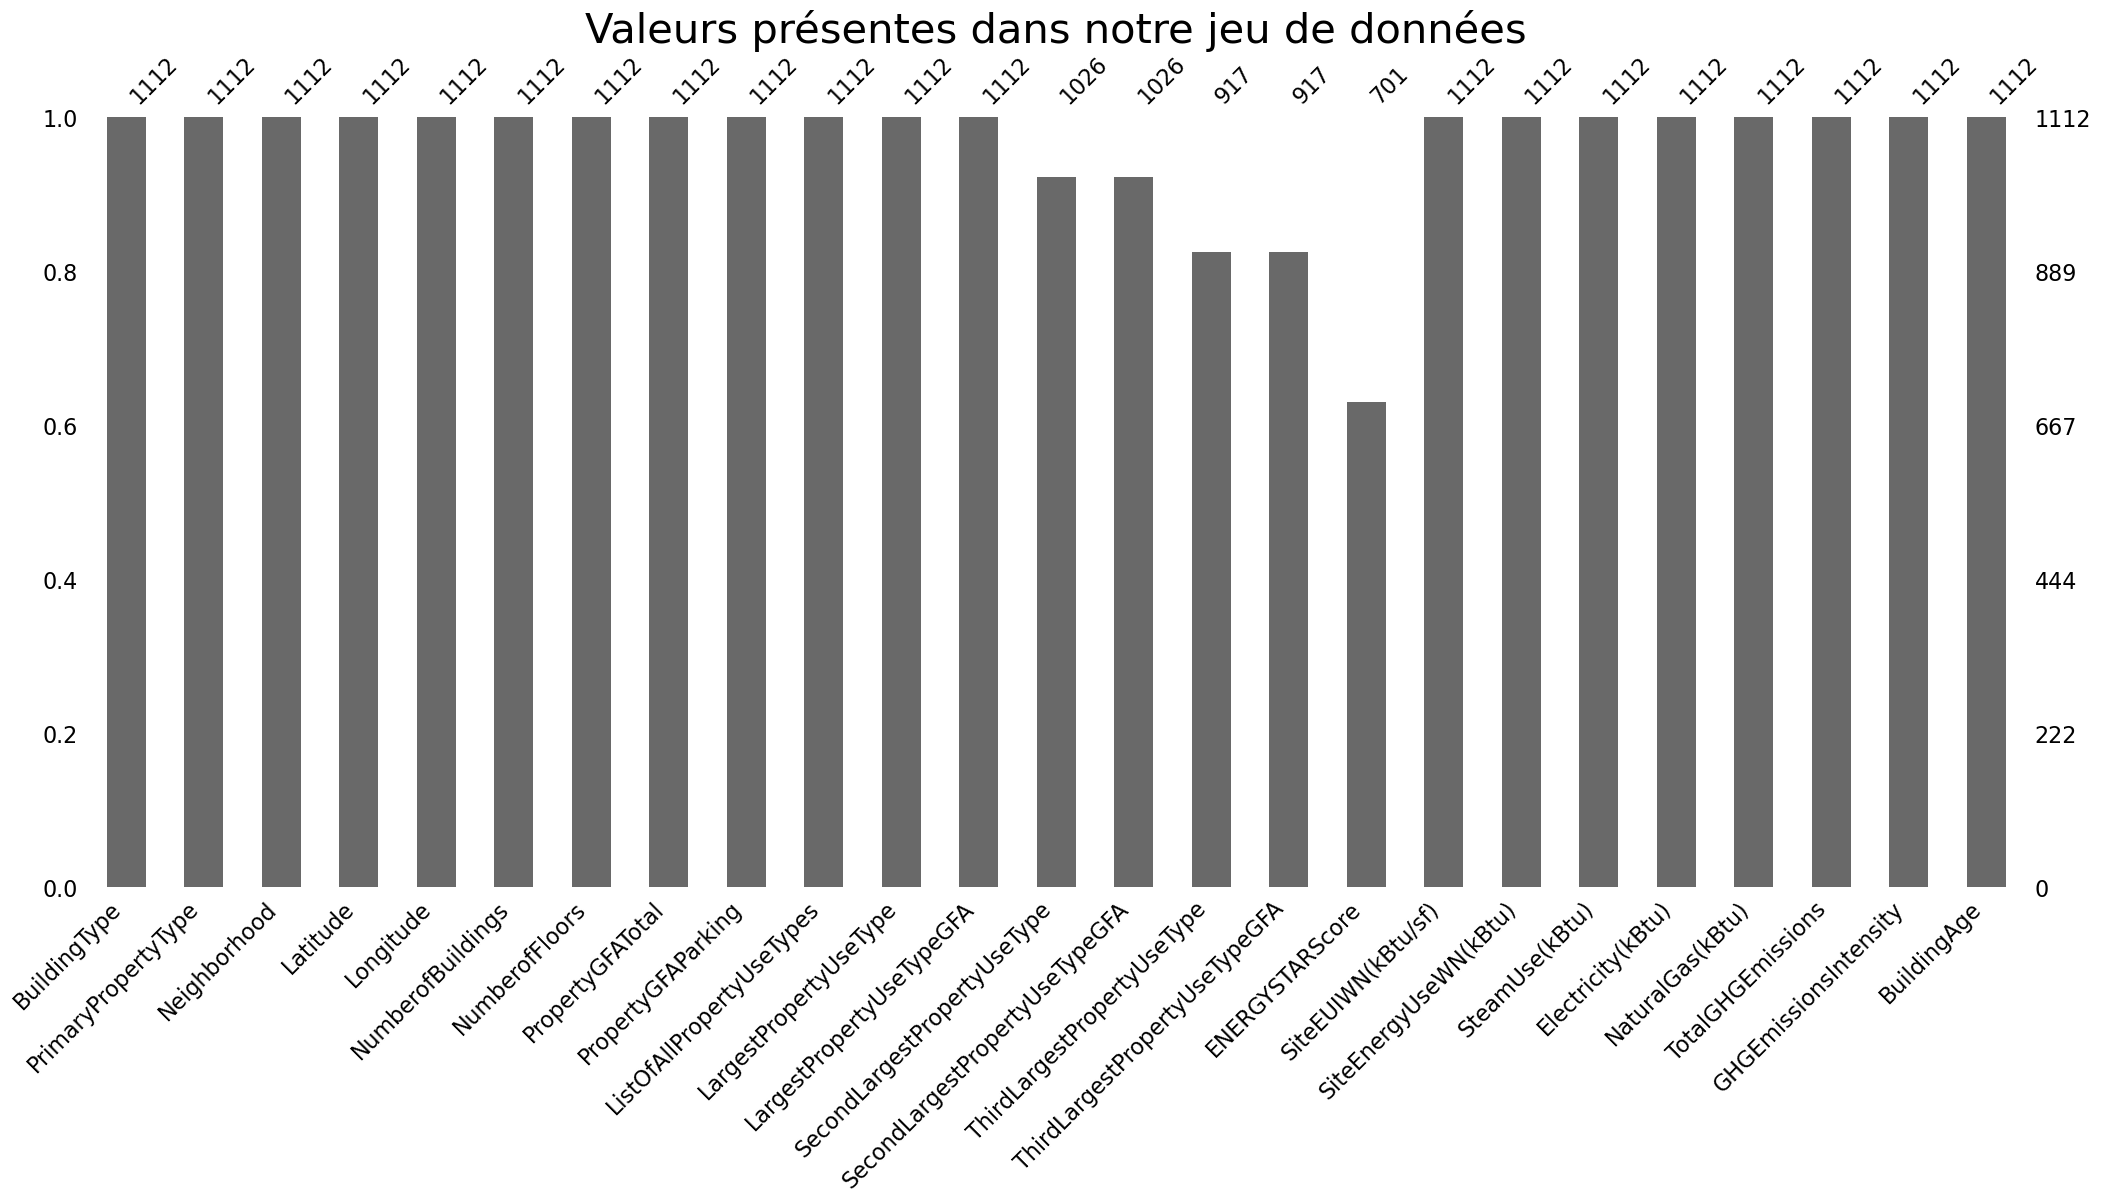

In [108]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_completed)

### Calcul

L'utilisation des propriétés est cruciale pour notre etude, nous allons tenter de compléter les valeurs manquantes

In [109]:
def fill_missing_types_and_calculate_gfa(row):
    largest_gfa = row['LargestPropertyUseTypeGFA']
    parking_gfa = row['PropertyGFAParking']
    
    # Pour SecondLargestPropertyUseType
    gfa_diff = row['PropertyGFATotal'] - largest_gfa - parking_gfa
    if pd.isna(row['SecondLargestPropertyUseType']) or gfa_diff == 0:
        row['SecondLargestPropertyUseType'] = "None"  
        row['SecondLargestPropertyUseTypeGFA'] = 0
    elif pd.isna(row['SecondLargestPropertyUseType']) and gfa_diff != 0:
        row['SecondLargestPropertyUseType'] = "Other" 
        row['SecondLargestPropertyUseTypeGFA'] = gfa_diff  

    # Assurer que ThirdLargestPropertyUseType est défini comme "None" si SecondLargestPropertyUseType est "None"
    if row['SecondLargestPropertyUseType'] == "None" or pd.isna(row['ThirdLargestPropertyUseType']):
        row['ThirdLargestPropertyUseType'] = "None"
        row['ThirdLargestPropertyUseTypeGFA'] = 0
    else:
        # Calcul pour ThirdLargestPropertyUseTypeGFA 
        second_largest_gfa = row['SecondLargestPropertyUseTypeGFA']
        third_gfa_diff = row['PropertyGFATotal'] - largest_gfa - second_largest_gfa - parking_gfa
        if pd.isna(row['ThirdLargestPropertyUseType']) or third_gfa_diff == 0:
            row['ThirdLargestPropertyUseType'] = "None"  
            row['ThirdLargestPropertyUseTypeGFA'] = 0
        elif pd.isna(row['SecondLargestPropertyUseType']) and third_gfa_diff != 0:
            row['ThirdLargestPropertyUseType'] = "Other" 
            row['ThirdLargestPropertyUseTypeGFA'] = gfa_diff  

    return row

# Appliquer la fonction pour ajuster les valeurs de Type et calculer les GFA
df_completed = df_completed.apply(fill_missing_types_and_calculate_gfa, axis=1)


In [110]:
def calculate_EnergyUse(row):
    if (row['SiteEnergyUseWN(kBtu)'] == 0):
        row['SiteEnergyUseWN(kBtu)'] = (row['Electricity(kBtu)'] if pd.notna(row['Electricity(kBtu)']) else 0) + \
        (row['SteamUse(kBtu)'] if pd.notna(row['SteamUse(kBtu)']) else 0) + \
        (row['NaturalGas(kBtu)'] if pd.notna(row['NaturalGas(kBtu)']) else 0)

    return row

# Appliquer la fonction pour ajuster les valeurs
df_completed = df_completed.apply(calculate_EnergyUse, axis=1)

In [111]:
missing_values_count = df_completed.isnull().sum()
total_cells = np.product(df_completed.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 1.48 %


<Axes: title={'center': 'Valeurs présentes dans notre jeu de données'}>

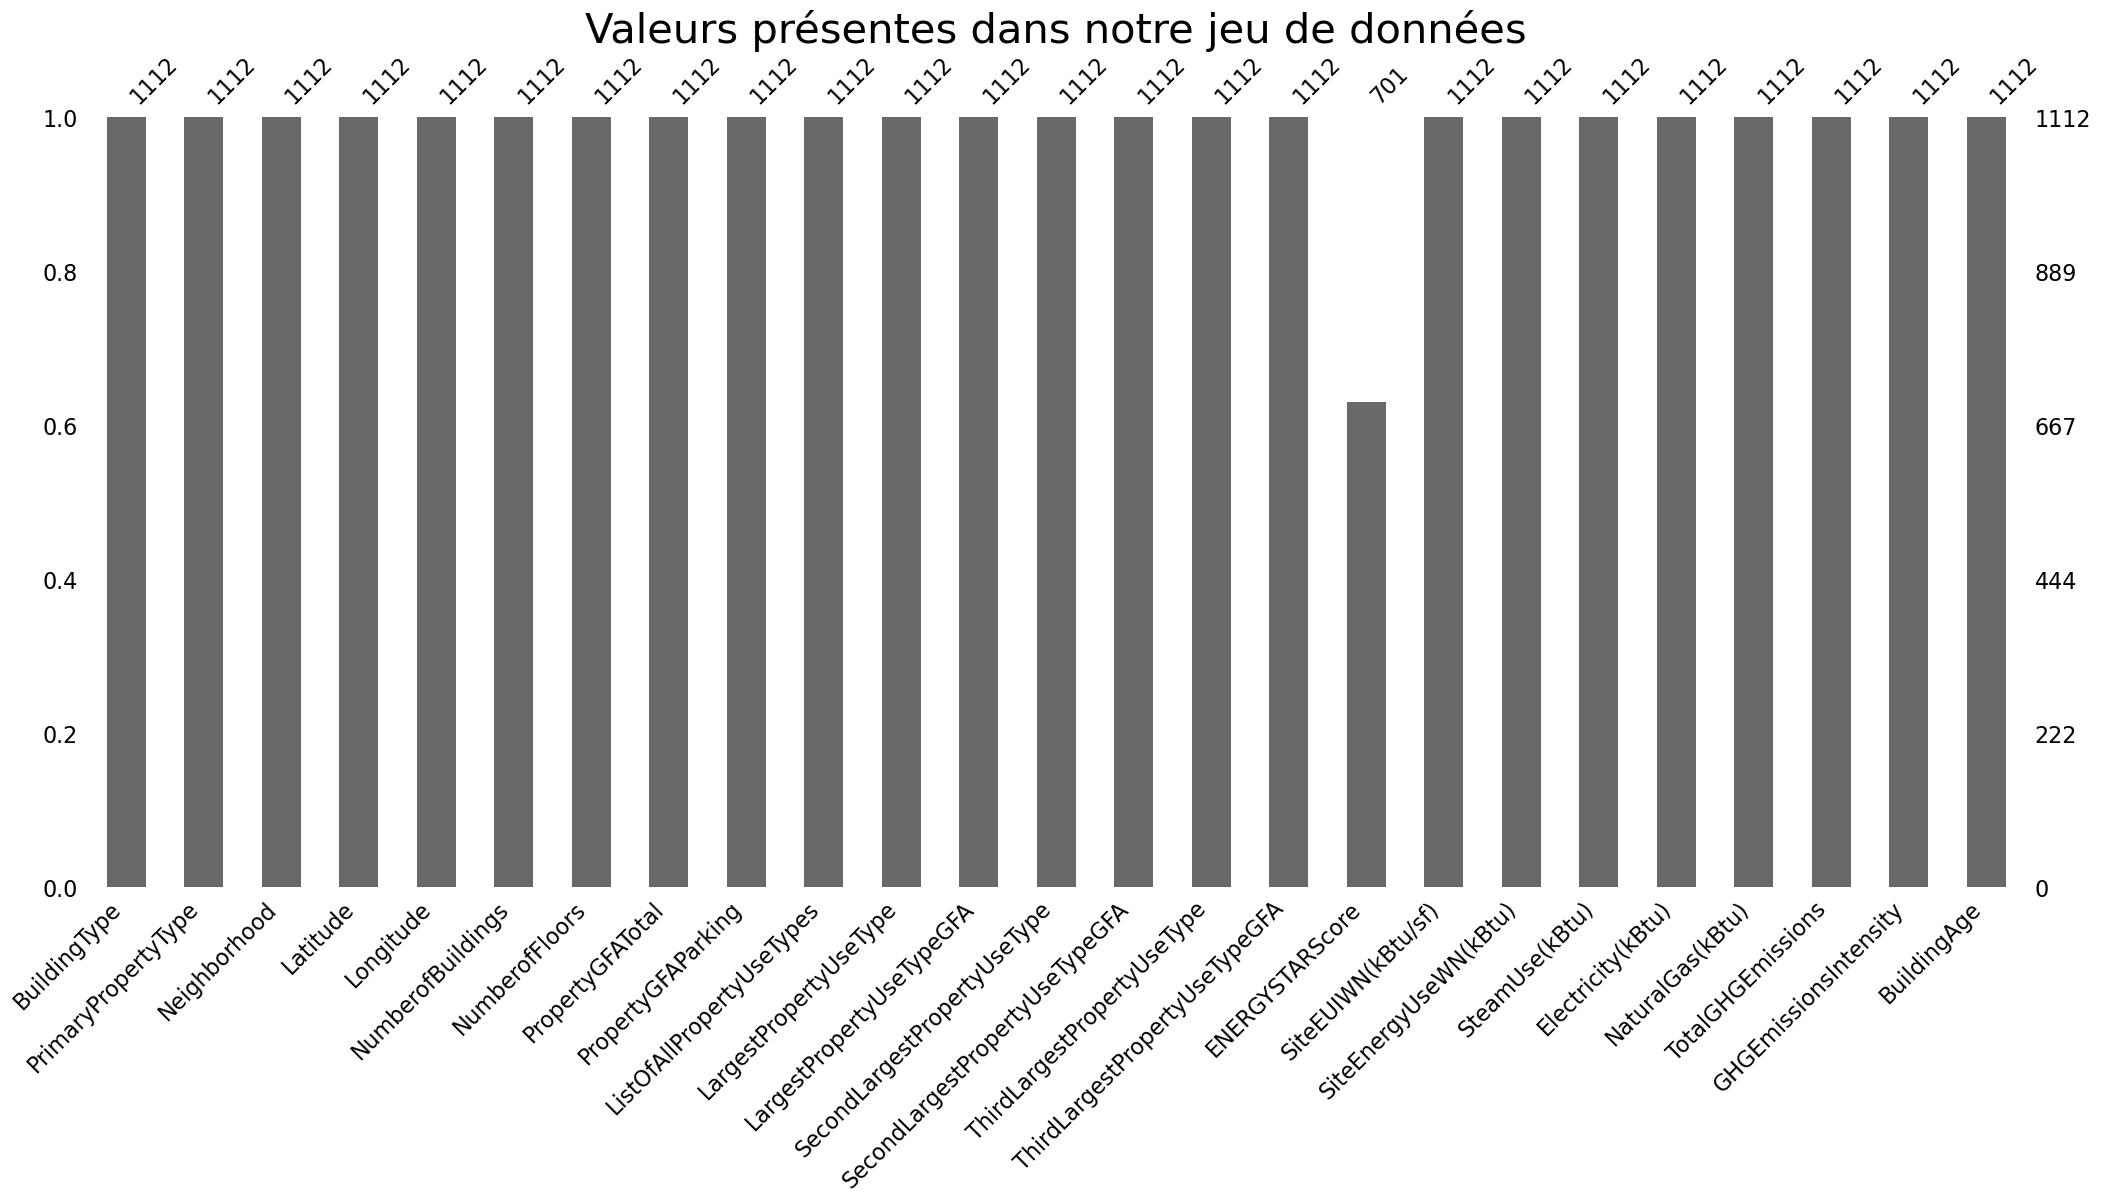

In [112]:
plt.title("Valeurs présentes dans notre jeu de données", fontsize=30)
msno.bar(df_completed)

Les données manquantes sont celles de l'EnergyStarScore, comme nous voulons en étudier l'intérêt pour nos modèles nous allons conserver un dataframe avec l'energystarscore à part.<br>

In [113]:
df = df_completed.copy()

In [114]:
df.shape

(1112, 25)

In [115]:
df_with_EnergyStarScore = df_completed.dropna()

In [116]:
df_with_EnergyStarScore.shape

(701, 25)

## Feature Engineering

### Nombre d'utilisations

In [117]:
# Compter le nombre d'éléments dans chaque cellule de la colonne ListOfAllPropertyUseTypes
# avec gestion des valeurs NaN
df['NumberOfPropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].apply(lambda x: len(x.split(',')) if pd.notna(x) else 0)

# Pour toutes les valeurs à 0 de NumberOfPropertyUseTypes, ajuster en fonction de l'existence de Third et SecondLargestPropertyUseType
for index, row in df.iterrows():
    if row['NumberOfPropertyUseTypes'] == 0:
        if row['ThirdLargestPropertyUseTypes'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 3
        elif row['SecondLargestPropertyUseType'] != 'None':
            df.at[index, 'NumberOfPropertyUseTypes'] = 2
        else:
            df.at[index, 'NumberOfPropertyUseTypes'] = 1

# Supprimer l'ancienne colonne
if 'ListOfAllPropertyUseTypes' in df.columns:
    df = df.drop(columns=['ListOfAllPropertyUseTypes'])


### Cas des parkings

In [118]:
number_of_1use_parking = len(df[df['LargestPropertyUseType'] == 'Parking'])
number_of_2use_parking = len(df[df['SecondLargestPropertyUseType'] == 'Parking'])
number_of_3use_parking = len(df[df['ThirdLargestPropertyUseType'] == 'Parking'])
print(number_of_1use_parking, number_of_2use_parking, number_of_3use_parking)

0 125 26


In [119]:
def update_parking_usage(row):
    if row['ThirdLargestPropertyUseType'] == "Parking":
        if row['ThirdLargestPropertyUseTypeGFA'] < row['PropertyGFAParking']:
            row['PropertyGFAParking'] = row['ThirdLargestPropertyUseTypeGFA']
        row['ThirdLargestPropertyUseType'] = np.nan
        row['ThirdLargestPropertyUseTypeGFA'] = np.nan    
    
    if row['SecondLargestPropertyUseType'] == "Parking":
        if row['SecondLargestPropertyUseTypeGFA'] < row['PropertyGFAParking']:
            row['PropertyGFAParking'] = row['SecondLargestPropertyUseTypeGFA']
        row['SecondLargestPropertyUseType'] = row['ThirdLargestPropertyUseType']
        row['SecondLargestPropertyUseTypeGFA'] = row['ThirdLargestPropertyUseTypeGFA']
        row['ThirdLargestPropertyUseType'] = np.nan
        row['ThirdLargestPropertyUseTypeGFA'] = np.nan
    return row

# Appliquer la fonction à chaque ligne du DataFrame
df = df.apply(update_parking_usage, axis=1)
df = df.apply(fill_missing_types_and_calculate_gfa, axis=1)

In [120]:
number_of_1use_parking = len(df[df['LargestPropertyUseType'] == 'Parking'])
number_of_2use_parking = len(df[df['SecondLargestPropertyUseType'] == 'Parking'])
number_of_3use_parking = len(df[df['ThirdLargestPropertyUseType'] == 'Parking'])
print(number_of_1use_parking, number_of_2use_parking, number_of_3use_parking)

0 0 0


### Passage en pourcentage de GFA par type d'utilisation

In [121]:
# Calculer le pourcentage pour le plus grand usage du bâtiment
df['LargestPropertyUseTypeGFA_pct'] = (df['LargestPropertyUseTypeGFA'] / 
                                            df['PropertyGFATotal']) * 100

# Calculer le pourcentage pour le deuxième plus grand usage du bâtiment
df['SecondLargestPropertyUseTypeGFA_pct'] = (df['SecondLargestPropertyUseTypeGFA'] / 
                                                  df['PropertyGFATotal']) * 100

# Calculer le pourcentage pour le troisième plus grand usage du bâtiment
df['ThirdLargestPropertyUseTypeGFA_pct'] = (df['ThirdLargestPropertyUseTypeGFA'] / 
                                                 df['PropertyGFATotal']) * 100

# Calculer le pourcentage pour le parking du bâtiment
df['PropertyGFAParking_pct'] = (df['PropertyGFAParking'] / 
                                     df['PropertyGFATotal']) * 100

# Supprimer les anciennes colonnes
df = df.drop(columns=['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA','PropertyGFAParking'])


In [122]:
def adjust_percentages(row):
    # Calculer la somme totale des pourcentages actuels
    total_pct = row['LargestPropertyUseTypeGFA_pct'] + row['SecondLargestPropertyUseTypeGFA_pct'] + row['ThirdLargestPropertyUseTypeGFA_pct'] + row['PropertyGFAParking_pct']
    
    # Ajuster chaque pourcentage pour que la somme soit égale à 100%
    row['LargestPropertyUseTypeGFA_pct'] = (row['LargestPropertyUseTypeGFA_pct'] / total_pct) * 100
    row['SecondLargestPropertyUseTypeGFA_pct'] = (row['SecondLargestPropertyUseTypeGFA_pct'] / total_pct) * 100
    row['ThirdLargestPropertyUseTypeGFA_pct'] = (row['ThirdLargestPropertyUseTypeGFA_pct'] / total_pct) * 100
    row['PropertyGFAParking_pct'] = (row['PropertyGFAParking_pct'] / total_pct) * 100

    return row

# Appliquer la fonction pour ajuster les pourcentages à chaque ligne du DataFrame
df = df.apply(adjust_percentages, axis=1)

In [123]:
df.head(5)

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0  NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1  NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
2  NonResidential               Hotel     DOWNTOWN  47.61393 -122.33810   
3  NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
6  NonResidential               Hotel     DOWNTOWN  47.61390 -122.33283   

   NumberofBuildings  NumberofFloors  PropertyGFATotal LargestPropertyUseType  \
0                1.0              12             88434                  Hotel   
1                1.0              11            103566                  Hotel   
2                1.0              41            956110                  Hotel   
3                1.0              10             61320                  Hotel   
6                1.0              11             83008                  Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType  ENERGYSTARScore  \
0                         None                        None             60.0   
1                   Restaurant                        None             61.0   
2                         None                        None             43.0   
3                         None                        None             56.0   
6                         None                        None             27.0   

   SiteEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0           84.300003              7456910.0      2003882.00   
1           97.900002              8664479.0            0.00   
2           97.699997             73937112.0     21566554.00   
3          113.300003              6946800.5      2214446.25   
6           74.500000              6062767.5            0.00   

   Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0          3946027.0         1276453.0             249.98   
1          3242851.0         5145082.0             295.86   
2         49526664.0         1493800.0            2089.28   
3          2768924.0         1811213.0             286.43   
6          2811215.0         2947580.0             176.14   

   GHGEmissionsIntensity  BuildingAge  NumberOfPropertyUseTypes  \
0                   2.83           89                         1   
1                   2.86           20                         3   
2                   2.19           47                         1   
3                   4.67           90                         1   
6                   2.12           90                         1   

   LargestPropertyUseTypeGFA_pct  SecondLargestPropertyUseTypeGFA_pct  \
0                     100.000000                             0.000000   
1                      80.991831                             4.462855   
2                      79.362597                             0.000000   
3                     100.000000                             0.000000   
6                     100.000000                             0.000000   

   ThirdLargestPropertyUseTypeGFA_pct  PropertyGFAParking_pct  
0                                 0.0                0.000000  
1                                 0.0               14.545314  
2                                 0.0               20.637403  
3                                 0.0                0.000000  
6                                 0.0                0.000000

### Traitement des fuites de données

Electricity(kBtu), SteamUse(kBtu) et NaturalGas(kBtu) sont des fuites de données. Nous ne voulons pas les récupérer pour nos prédictions mais nous pouvons tout de même savoir leur taux d'utilisation dans le bâtiment.

In [124]:
cols_energie = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

# Calcul du pourcentage d'utilisation pour chaque type d'énergie
for col in cols_energie:
    new_col_name = col.replace('(kBtu)', '') + '_pct'
    df[new_col_name] = (df[col] / df['SiteEnergyUseWN(kBtu)']) * 100

# supprimer les colonnes des energie kBtu
df = df.drop(columns=cols_energie).copy()

In [125]:
df.head(5)

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0  NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1  NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
2  NonResidential               Hotel     DOWNTOWN  47.61393 -122.33810   
3  NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
6  NonResidential               Hotel     DOWNTOWN  47.61390 -122.33283   

   NumberofBuildings  NumberofFloors  PropertyGFATotal LargestPropertyUseType  \
0                1.0              12             88434                  Hotel   
1                1.0              11            103566                  Hotel   
2                1.0              41            956110                  Hotel   
3                1.0              10             61320                  Hotel   
6                1.0              11             83008                  Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType  ENERGYSTARScore  \
0                         None                        None             60.0   
1                   Restaurant                        None             61.0   
2                         None                        None             43.0   
3                         None                        None             56.0   
6                         None                        None             27.0   

   SiteEUIWN(kBtu/sf)  SiteEnergyUseWN(kBtu)  TotalGHGEmissions  \
0           84.300003              7456910.0             249.98   
1           97.900002              8664479.0             295.86   
2           97.699997             73937112.0            2089.28   
3          113.300003              6946800.5             286.43   
6           74.500000              6062767.5             176.14   

   GHGEmissionsIntensity  BuildingAge  NumberOfPropertyUseTypes  \
0                   2.83           89                         1   
1                   2.86           20                         3   
2                   2.19           47                         1   
3                   4.67           90                         1   
6                   2.12           90                         1   

   LargestPropertyUseTypeGFA_pct  SecondLargestPropertyUseTypeGFA_pct  \
0                     100.000000                             0.000000   
1                      80.991831                             4.462855   
2                      79.362597                             0.000000   
3                     100.000000                             0.000000   
6                     100.000000                             0.000000   

   ThirdLargestPropertyUseTypeGFA_pct  PropertyGFAParking_pct  SteamUse_pct  \
0                                 0.0                0.000000     26.872820   
1                                 0.0               14.545314      0.000000   
2                                 0.0               20.637403     29.168781   
3                                 0.0                0.000000     31.877211   
6                                 0.0                0.000000      0.000000   

   Electricity_pct  NaturalGas_pct  
0        52.917723       17.117720  
1        37.426959       59.381320  
2        66.984851        2.020366  
3        39.858983       26.072621  
6        46.368511       48.617731

# Analyse Exploratoire des Données

## Analyse Univariée

### Variables numériques

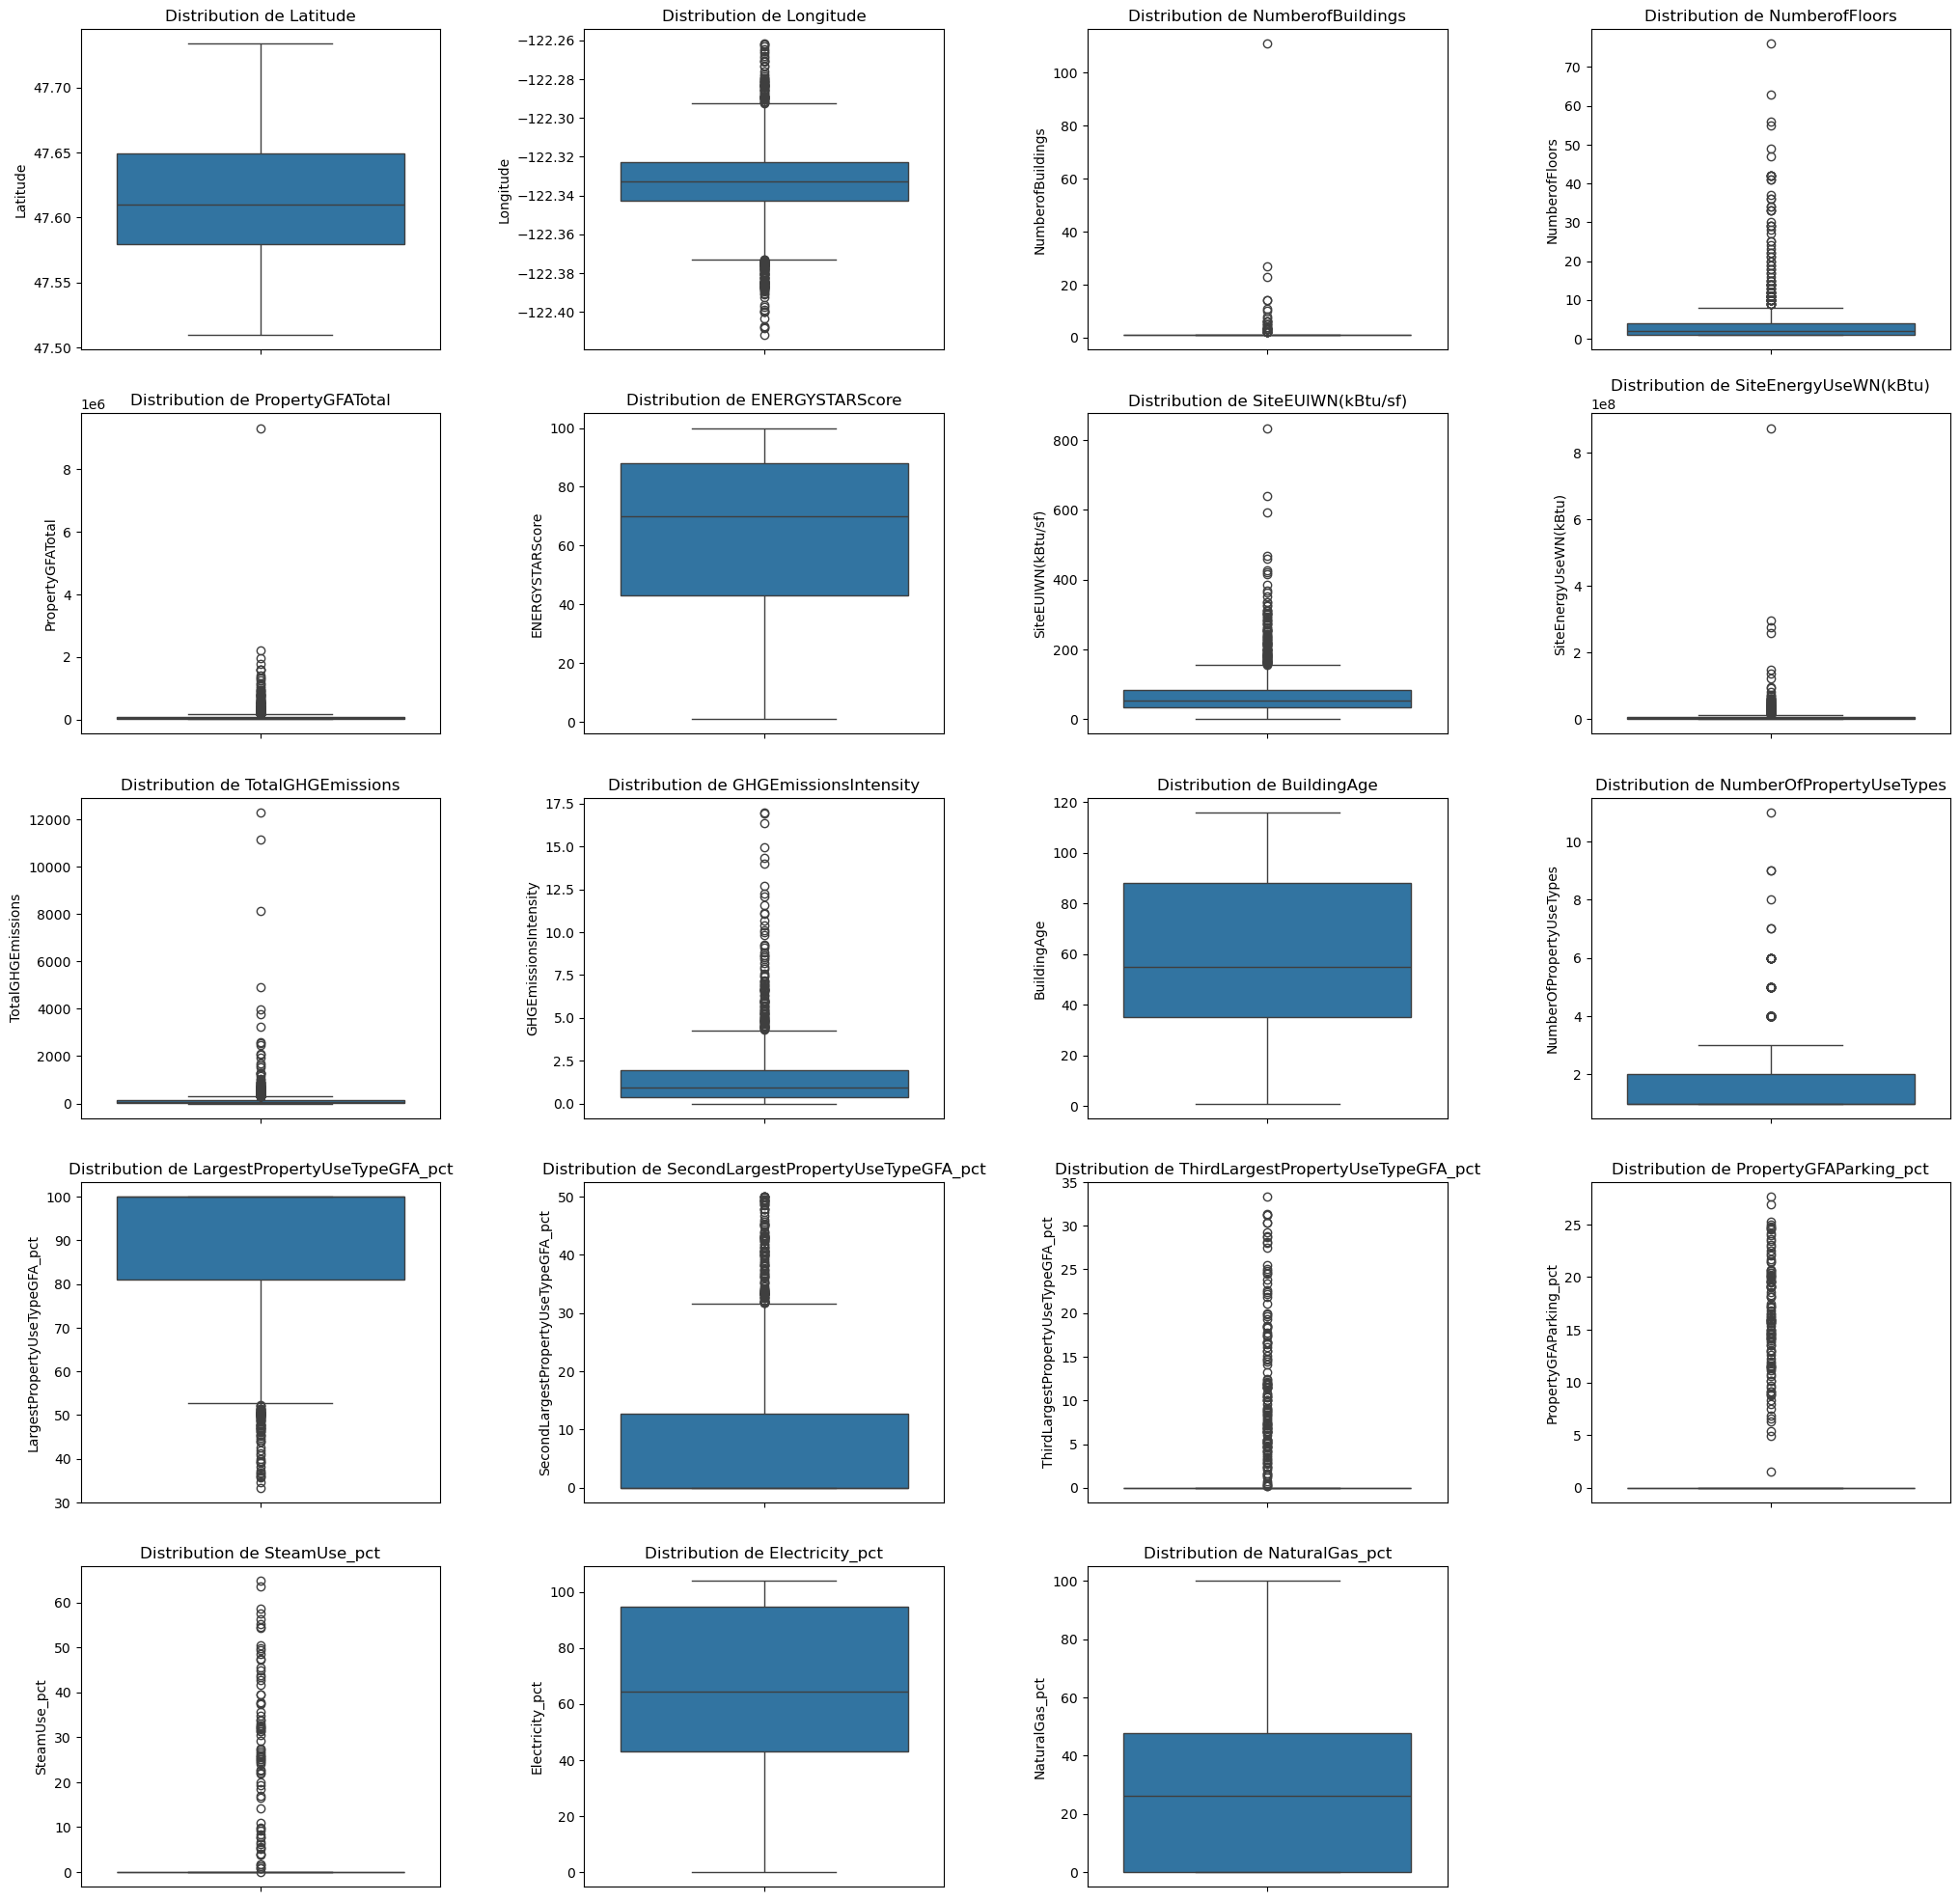

In [126]:
# Sélectionner uniquement les colonnes numériques
numerics_col = df.select_dtypes(include=['number'])

# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,25))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.boxplot(y=df[column], ax=ax)
    ax.set_title(f'Distribution de {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 20):
    fig.delaxes(axes.flatten()[j])

plt.show()

In [127]:
df.describe()

Latitude    Longitude  NumberofBuildings  NumberofFloors  \
count  1112.000000  1112.000000        1112.000000     1112.000000   
mean     47.613698  -122.333602           1.252698        4.025180   
std       0.049381     0.024290           3.550838        6.822113   
min      47.509590  -122.411820           1.000000        1.000000   
25%      47.579408  -122.342765           1.000000        1.000000   
50%      47.609800  -122.332885           1.000000        2.000000   
75%      47.649100  -122.322700           1.000000        4.000000   
max      47.733680  -122.261800         111.000000       76.000000   

       PropertyGFATotal  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
count      1.112000e+03       701.000000         1112.000000   
mean       1.108670e+05        63.078459           72.599461   
std        3.413120e+05        28.737250           72.742630   
min        1.128500e+04         1.000000            0.000000   
25%        2.712925e+04        43.000000           33.775000   
50%        4.343150e+04        70.000000           53.049999   
75%        8.727950e+04        88.000000           82.925001   
max        9.320156e+06       100.000000          834.400024   

       SiteEnergyUseWN(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity  \
count           1.112000e+03        1112.000000            1112.000000   
mean            8.155953e+06         169.374182               1.644577   
std             3.219431e+07         643.628043               2.136962   
min             0.000000e+00           0.000000               0.000000   
25%             1.183504e+06          18.720000               0.390000   
50%             2.389630e+06          46.350000               0.925000   
75%             6.198826e+06         132.627500               1.965000   
max             8.739237e+08       12307.160000              16.990000   

       BuildingAge  NumberOfPropertyUseTypes  LargestPropertyUseTypeGFA_pct  \
count  1112.000000               1112.000000                    1112.000000   
mean     58.438849                  1.830935                      88.776403   
std      31.555415                  1.181242                      16.877088   
min       1.000000                  1.000000                      33.333333   
25%      35.000000                  1.000000                      80.913835   
50%      55.000000                  1.000000                     100.000000   
75%      88.000000                  2.000000                     100.000000   
max     116.000000                 11.000000                     100.000000   

       SecondLargestPropertyUseTypeGFA_pct  \
count                          1112.000000   
mean                              8.091769   
std                              13.736783   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                              12.663143   
max                              50.000000   

       ThirdLargestPropertyUseTypeGFA_pct  PropertyGFAParking_pct  \
count                         1112.000000             1112.000000   
mean                             1.498339                1.633489   
std                              4.948468                5.148413   
min                              0.000000                0.000000   
25%                              0.000000                0.000000   
50%                              0.000000                0.000000   
75%                              0.000000                0.000000   
max                             33.333333               27.637240   

       SteamUse_pct  Electricity_pct  NaturalGas_pct  
count   1109.000000      1109.000000     1109.000000  
mean       2.057110        65.397990       27.272598  
std        8.655708        27.444465       24.483969  
min        0.000000         0.000000        0.000000  
25%        0.000000        43.086418        0.000000  
50%        0.000000        64.341640       26.074393  
7

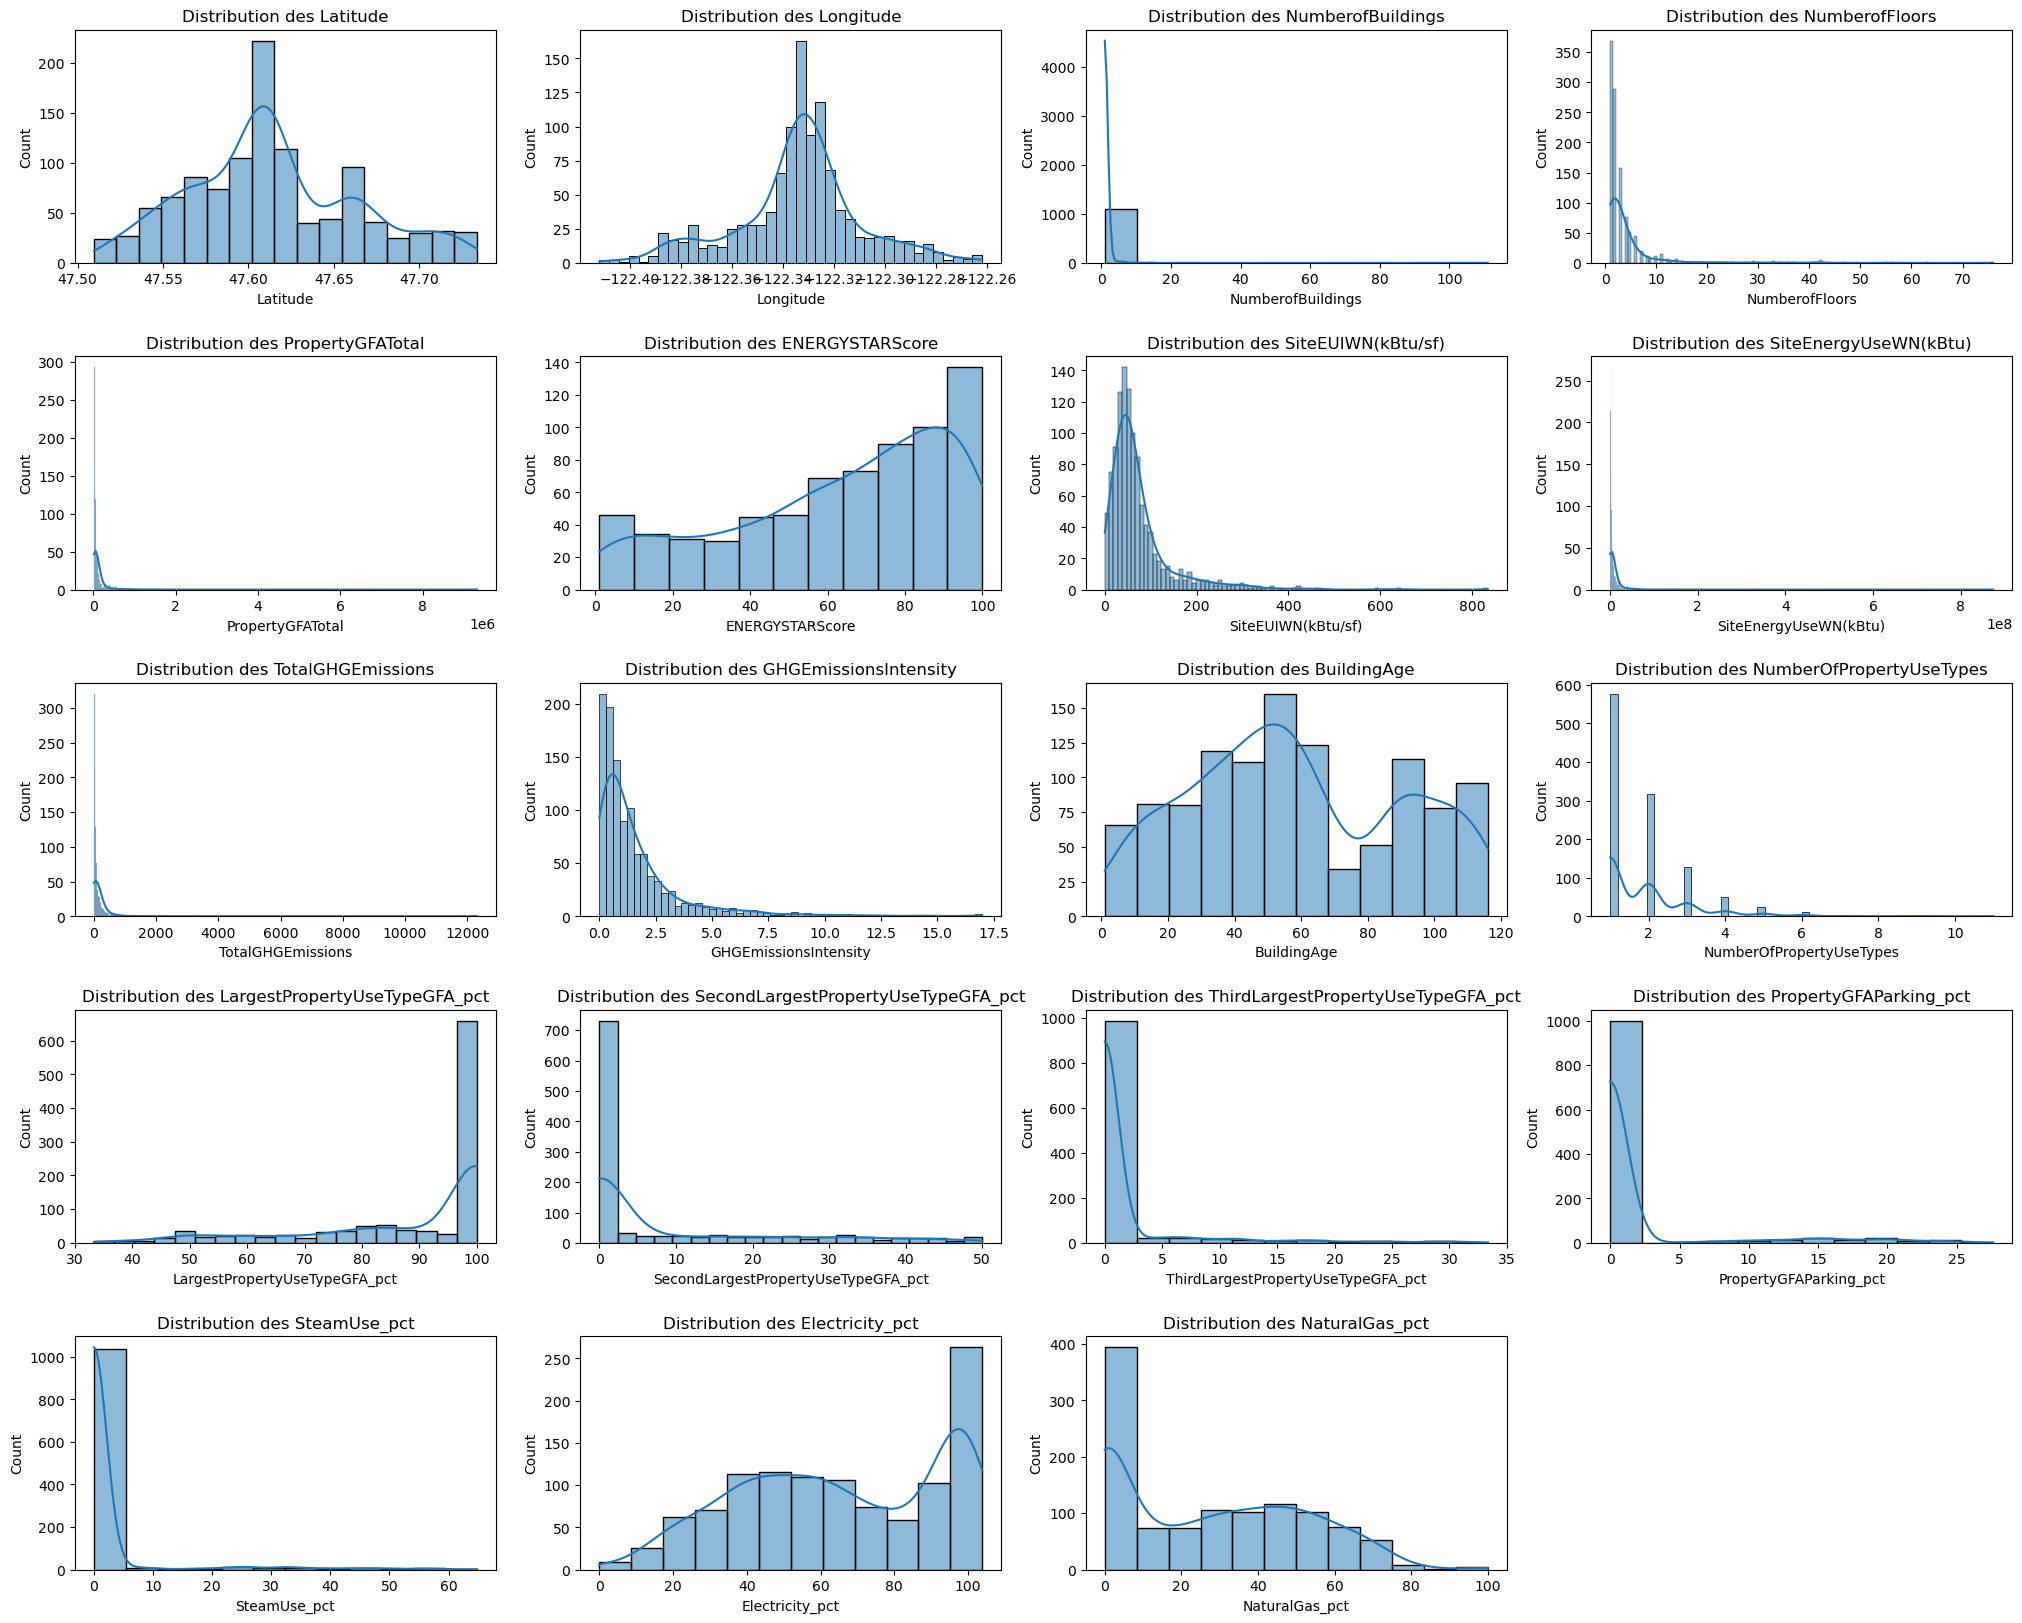

In [128]:
# Créer une figure avec des sous-graphiques pour chaque colonne numérique
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25,20))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.4)

# Density plot
for i, (ax, column) in enumerate(zip(axes.flatten(), numerics_col)):
    sns.histplot(data=df, x=column, kde=True, ax=ax)
    ax.set_title(f'Distribution des {column}')

# Supprimer les axes vides si le nombre de colonnes numériques est inférieur au nombre total d'axes
for j in range(i + 1, 20):
    fig.delaxes(axes.flatten()[j])

plt.show()

Les variables cibles de notre étides sont fortement assymétriques. Nous allons faire un passage au Log pour voir la nouvelle distribution

In [129]:
# Compter le nombre de valeurs zéro ou négatives dans 'TotalGHGEmissions'
count_zero_neg_ghg = len(df[df['TotalGHGEmissions'] <= 0])

# Compter le nombre de valeurs zéro ou négatives dans 'SiteEnergyUse(kBtu)'
count_zero_neg_energy = len(df[df['SiteEnergyUseWN(kBtu)'] <= 0])

# Afficher les résultats
print(f"Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': {count_zero_neg_ghg}")
print(f"Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': {count_zero_neg_energy}")


Nombre de valeurs zéro ou négatives pour 'TotalGHGEmissions': 3
Nombre de valeurs zéro ou négatives pour 'SiteEnergyUseWN(kBtu)': 3


In [130]:
# Supprimer ces lignes
df = df[df['TotalGHGEmissions'] > 0]
df = df[df['SiteEnergyUseWN(kBtu)'] > 0]
df.shape

(1109, 25)

In [131]:
# Calculer le logarithme des colonnes 'TotalGHGEmissions' et 'SiteEnergyUseWN(kBtu)'
df = df.copy()
df['Log_TotalGHGEmissions'] = np.log(df['TotalGHGEmissions'])
df['Log_SiteEnergyUseWN'] = np.log(df['SiteEnergyUseWN(kBtu)'])

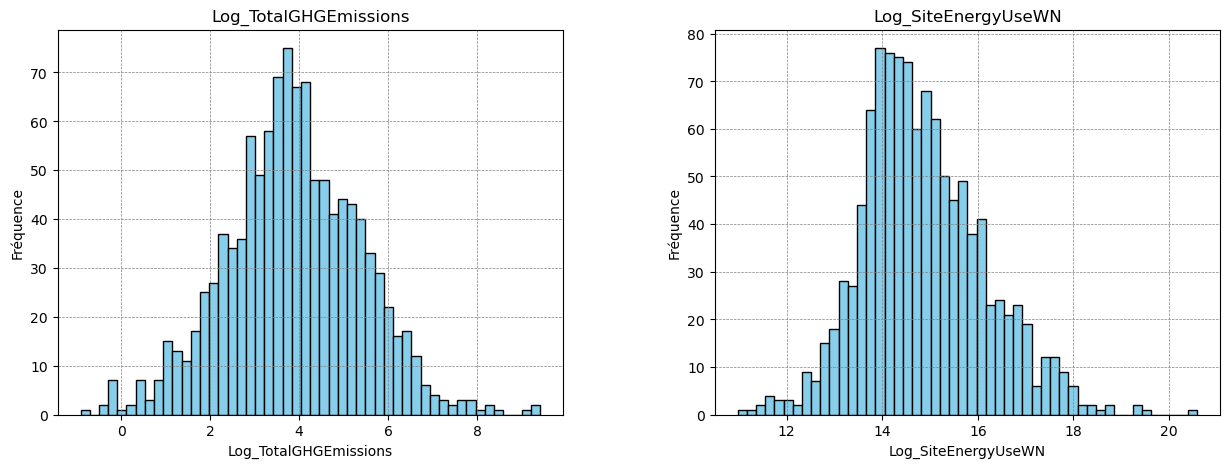

In [132]:
# Créez un histogramme pour TotalGHGEmissions et SiteEnergyUse(kBtu)
# Sélection des colonnes spécifiques
selected_columns = df[['Log_TotalGHGEmissions','Log_SiteEnergyUseWN']]

# Créez un histogramme pour chaque variable numérique sélectionnée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, column in zip(axes, selected_columns.columns):
    ax.hist(df[column], bins=50, edgecolor='black', color='skyblue')
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')
    # Ajouter un quadrillage
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
    
# Ajustez l'espace entre les subplots
plt.subplots_adjust(wspace=0.3)

# Affichez les histogrammes
plt.show()

### Variables catégorielles

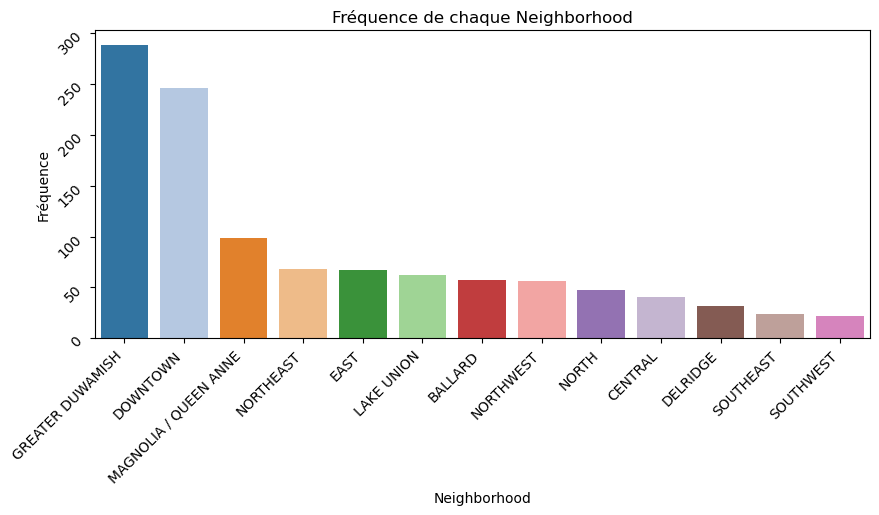

In [133]:
# Compter le nombre d'occurrences pour chaque Neighborhood
group_counts = df['Neighborhood'].value_counts().reset_index()
group_counts.columns = ['Neighborhood', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='Neighborhood', y='Counts', data=group_counts, hue='Neighborhood', palette="tab20", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque Neighborhood')
plt.ylabel('Fréquence')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45, ha="right")

plt.show()

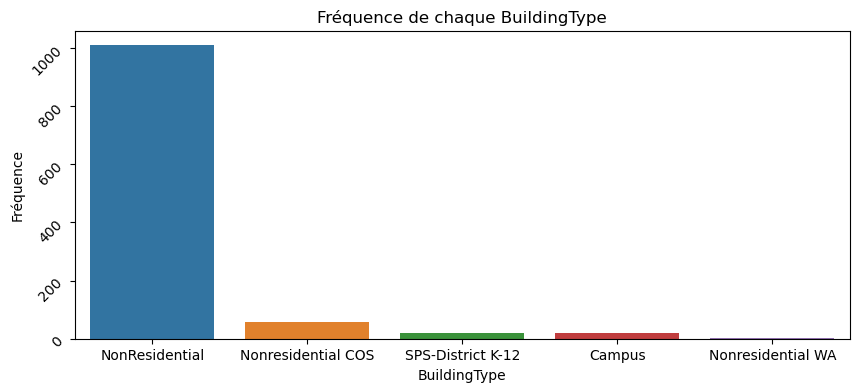

In [134]:
# Compter le nombre d'occurrences pour chaque BuildingType
group_counts = df['BuildingType'].value_counts().reset_index()
group_counts.columns = ['BuildingType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='BuildingType', y='Counts', data=group_counts, hue='BuildingType', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque BuildingType')
plt.ylabel('Fréquence')
plt.xlabel('BuildingType')

plt.show()

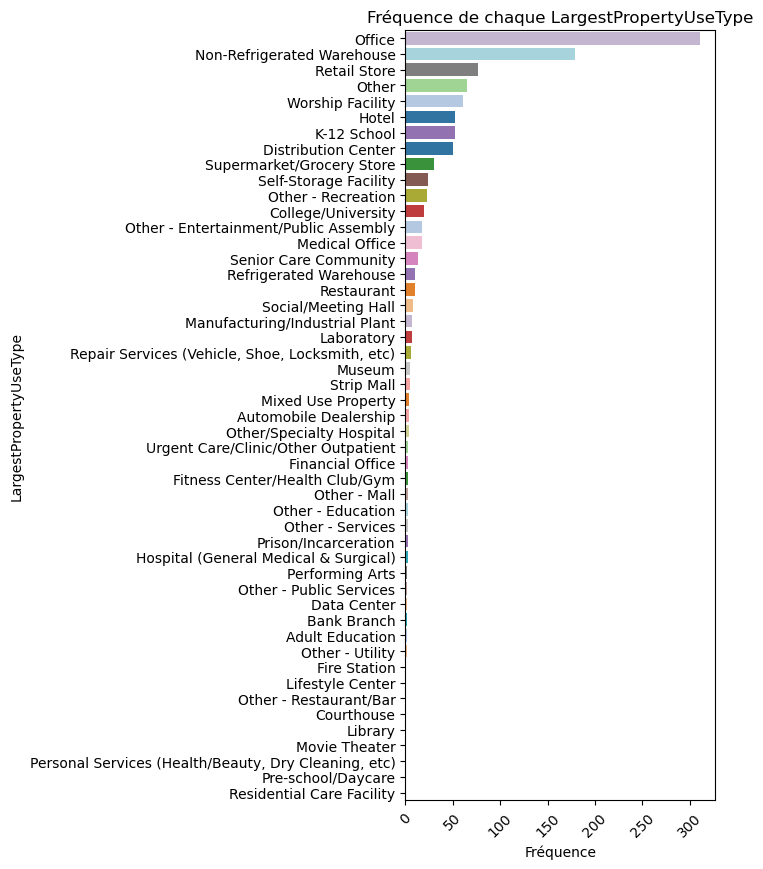

In [135]:
# LargestPropertyUseType
group_counts = df['LargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='LargestPropertyUseType', data=df, order=group_counts.index, hue='LargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque LargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('LargestPropertyUseType')

plt.show()

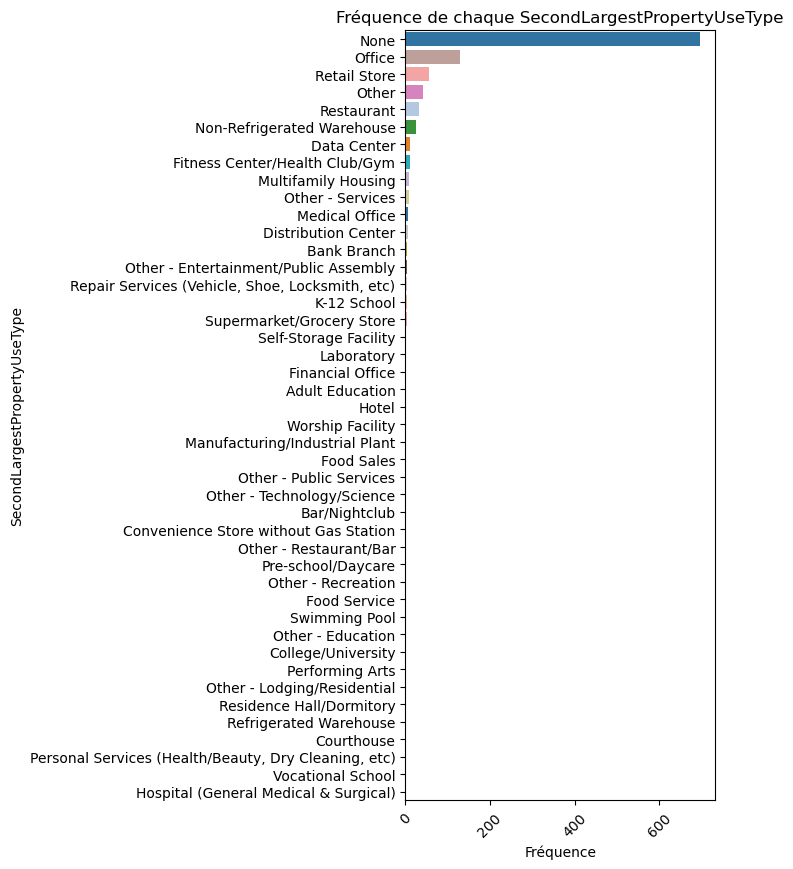

In [136]:
# SecondLargestPropertyUseType
group_counts = df['SecondLargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 10))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='SecondLargestPropertyUseType', data=df, order=group_counts.index, hue='SecondLargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque SecondLargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('SecondLargestPropertyUseType')

plt.show()

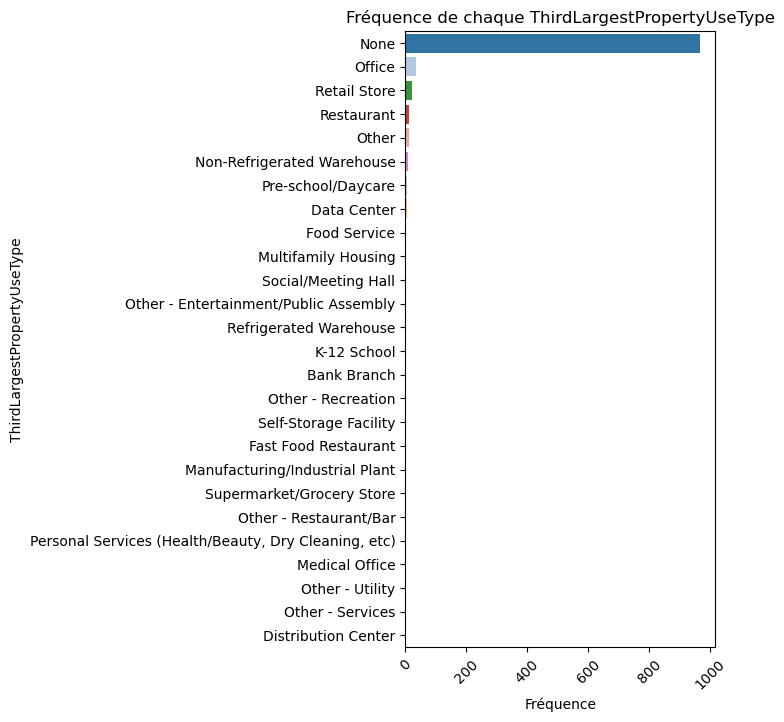

In [137]:
# ThirdLargestPropertyUseType
group_counts = df['ThirdLargestPropertyUseType'].value_counts()

plt.figure(figsize=(4, 8))

# Créer un graphique à barres avec des barres ordonnées par la fréquence (décroissante)
sns.countplot(y='ThirdLargestPropertyUseType', data=df, order=group_counts.index, hue='ThirdLargestPropertyUseType', palette="tab20", legend=False)

plt.xticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque ThirdLargestPropertyUseType')
plt.xlabel('Fréquence')
plt.ylabel('ThirdLargestPropertyUseType')

plt.show()

## Analyse Bivariée

### Variables numériques

In [138]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df.select_dtypes(include=['number']).columns

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df[numerics_col])

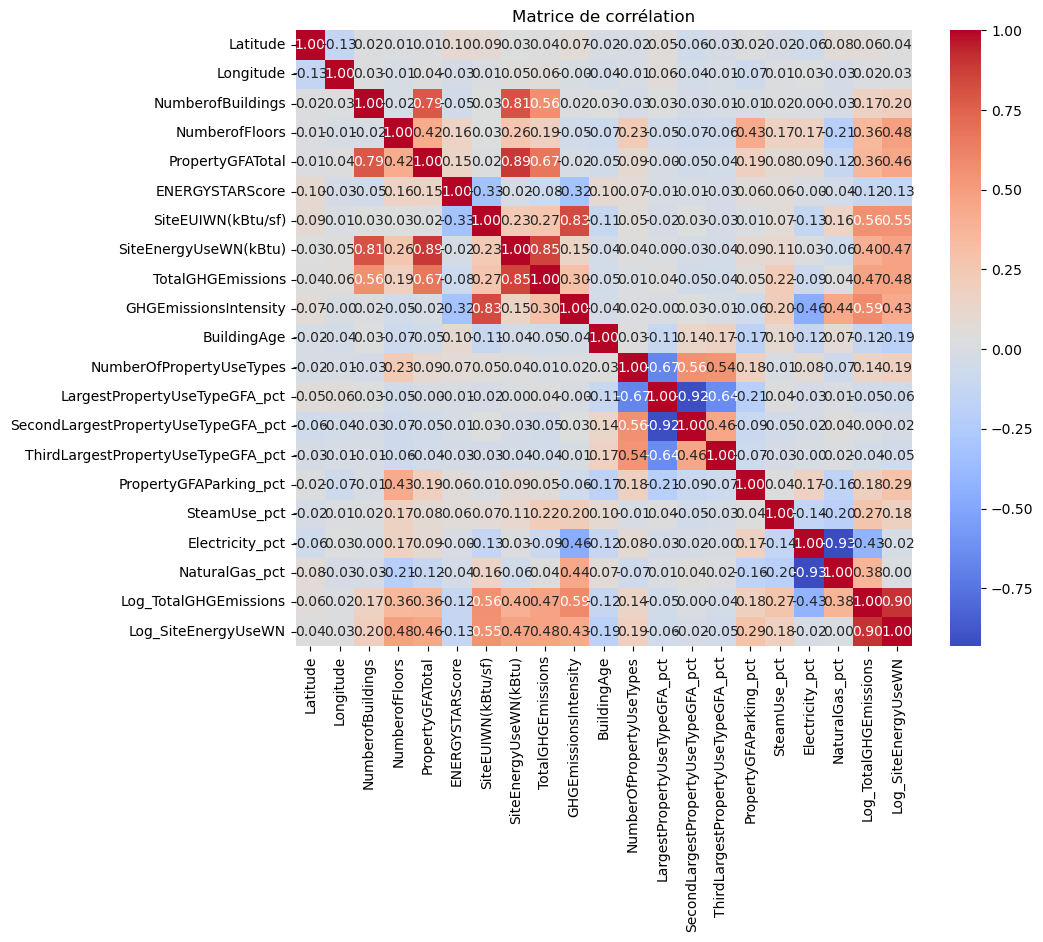

In [139]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()

=> pas de corrélation évidente entre latitude et  longitude et nos cibles, on remarque cependant que les bâtiments les plus grands semblent rassemblés au centre de la ville avec en plus une utilisation de SteamUse plus marquée pour ces bâtiments. Un indicateur géographique serait intéressant à regarder (voir nos catégories pour choisir le plus précis)<br>
=> on voit pas mal de corrélation assez complexes, pas de variable a écarter pour le moment

### Cibles par rapport aux variables catégorielles

In [140]:
def plot_boxplots_by_category(df, category):
    sns.set(style="whitegrid")

    # Lignes en fonction du nombre de catégories
    num_categories = len(df[category].unique())
    height_per_subplot = 3
    total_height = (num_categories * height_per_subplot) / 10

    # 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, total_height), constrained_layout=True)

    # Orderby median de SiteEnergyUseWN(kBtu)
    order_energy = df.groupby(category)['Log_SiteEnergyUseWN'].median().sort_values(ascending=False).index
    # SiteEnergyUseWN(kBtu) boxplot
    sns.boxplot(y=category, x='Log_SiteEnergyUseWN', data=df, orient='h', ax=axes[0], order=order_energy)
    axes[0].set_title(f'Log_SiteEnergyUseWN by {category}')
    axes[0].set_xlabel('Log_SiteEnergyUseWN')
    axes[0].set_ylabel(category)

    # Orderby median de  TotalGHGEmissions
    order_ghg = df.groupby(category)['Log_TotalGHGEmissions'].median().sort_values(ascending=False).index
    # TotalGHGEmissions boxplot
    sns.boxplot(y=category, x='Log_TotalGHGEmissions', data=df, orient='h', ax=axes[1], order=order_ghg)
    axes[1].set_title(f'Log_TotalGHGEmissions by {category}')
    axes[1].set_xlabel('Log_TotalGHGEmissions')
    axes[1].set_ylabel('')

    #plt.tight_layout()
    plt.show()


In [141]:
# Liste des variables catégorielles qu'on veut analyser
categorical_columns = ['Neighborhood']

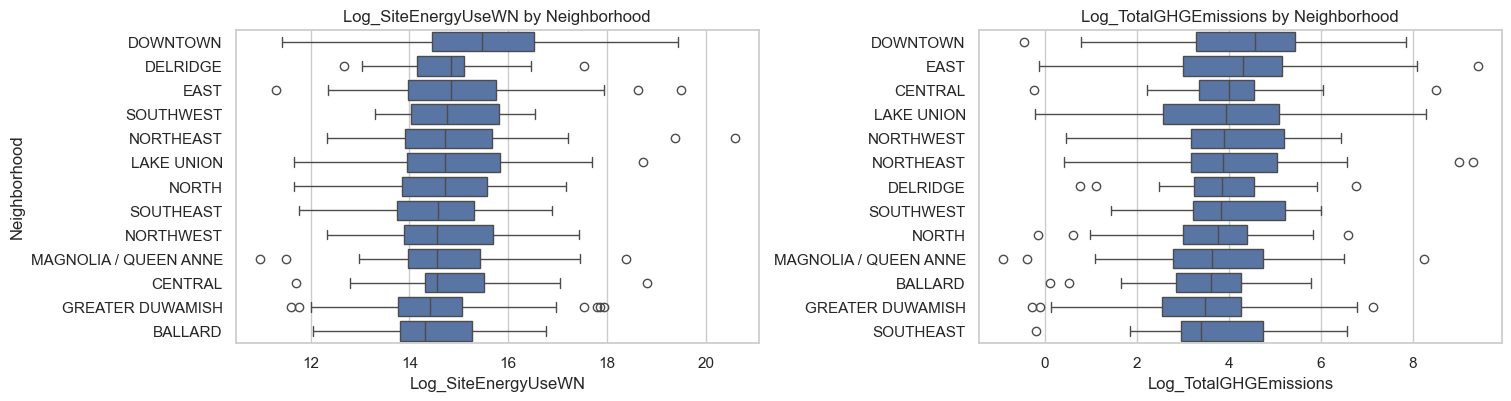

In [142]:
for category in categorical_columns:
    plot_boxplots_by_category(df, category)

## Analyse Multivariée (ANOVA)

In [143]:
def perform_anova_tukey(df, numeric_var, categorical_var):
    # Effectuez l'ANOVA
    formula = f"{numeric_var} ~ C({categorical_var})"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Effectuez le test de Tukey pour les comparaisons post-hoc
    tukey_result = pairwise_tukeyhsd(endog=df[numeric_var], groups=df[categorical_var], alpha=0.05)
    
    # Affichez les résultats
    print(f"ANOVA Table for {numeric_var} by {categorical_var}:")
    print(anova_table)
    print("\n")
    print(f"\nTukey's HSD Results for {numeric_var} by {categorical_var}:")
    print(tukey_result)



In [144]:
# Renommer la colonne pour ne pas avoir de probleme avec les caracteres spéciaux
df.rename(columns={'SiteEUIWN(kBtu/sf)': 'SiteEUIWN_kBtu_sf'}, inplace=True)

=> bon résultat avec 2 groupes

### Neighborhood

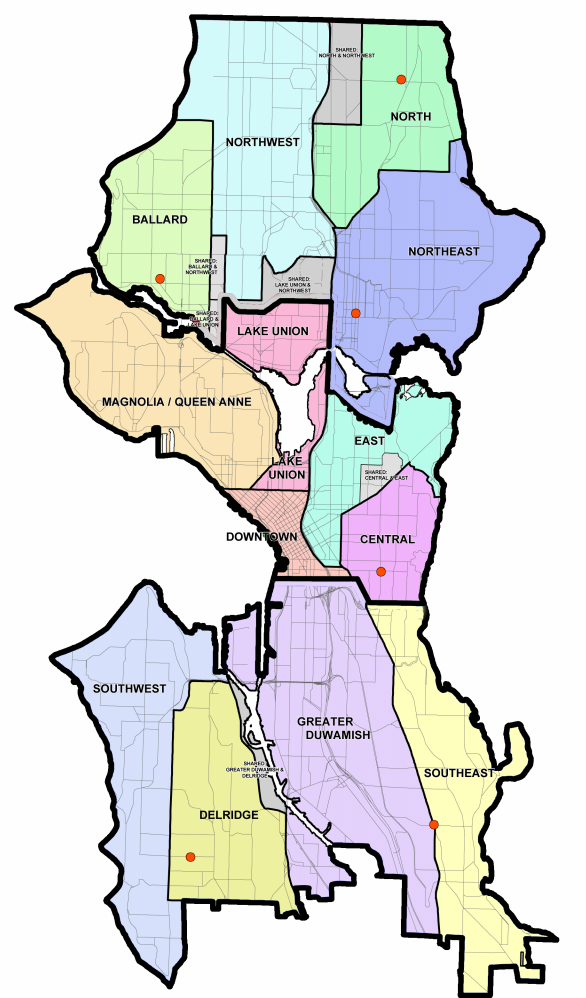

In [145]:
# Afficher les quartiers de Seattle
Image(filename="Map_of_Seattle,_divided_by_districts.png", width=400, height=150)

In [146]:
# Test avec un regroupement de catégories
def map_areas_neighborhood(neighborhood):
    # Zones résidentielles
    residential = ['EAST', 'NORTHEAST']
    
    # Zones urbaines et centres culturels
    urban_core = ['NORTHWEST', 'MAGNOLIA / QUEEN ANNE', 'BALLARD', 'CENTRAL', 'NORTH', 'LAKE UNION']
    
    # Zones commerces et industrielles
    commercial_industrial = ['DOWNTOWN', 'GREATER DUWAMISH', 'DELRIDGE', 'SOUTHEAST', 'SOUTHWEST']

    if neighborhood in residential:
        return 'residential'
    elif neighborhood in urban_core:
        return 'urban_core'
    else:
        return 'commercial_industrial'

df['GroupedNeighborhood'] = df['Neighborhood'].apply(map_areas_neighborhood)


In [147]:
perform_anova_tukey(df, 'SiteEUIWN_kBtu_sf', 'GroupedNeighborhood')

ANOVA Table for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
                              sum_sq      df         F    PR(>F)
C(GroupedNeighborhood)  1.151581e+05     2.0  11.07938  0.000017
Residual                5.747833e+06  1106.0       NaN       NaN



Tukey's HSD Results for SiteEUIWN_kBtu_sf by GroupedNeighborhood:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
        group1           group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------
commercial_industrial residential  30.4908    0.0  14.4036  46.578   True
commercial_industrial  urban_core  12.6221 0.0228   1.4042 23.8401   True
          residential  urban_core -17.8686 0.0376 -34.9302  -0.807   True
-------------------------------------------------------------------------


In [148]:
perform_anova_tukey(df, 'GHGEmissionsIntensity', 'GroupedNeighborhood')

ANOVA Table for GHGEmissionsIntensity by GroupedNeighborhood:
                             sum_sq      df          F        PR(>F)
C(GroupedNeighborhood)   136.131075     2.0  15.272249  2.866036e-07
Residual                4929.233673  1106.0        NaN           NaN



Tukey's HSD Results for GHGEmissionsIntensity by GroupedNeighborhood:
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
        group1           group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
commercial_industrial residential   1.0735    0.0  0.6024  1.5446   True
commercial_industrial  urban_core   0.3827 0.0175  0.0542  0.7112   True
          residential  urban_core  -0.6908 0.0035 -1.1904 -0.1911   True
------------------------------------------------------------------------


=> on a 3 groupes bien définis pour les conso et les emissions.

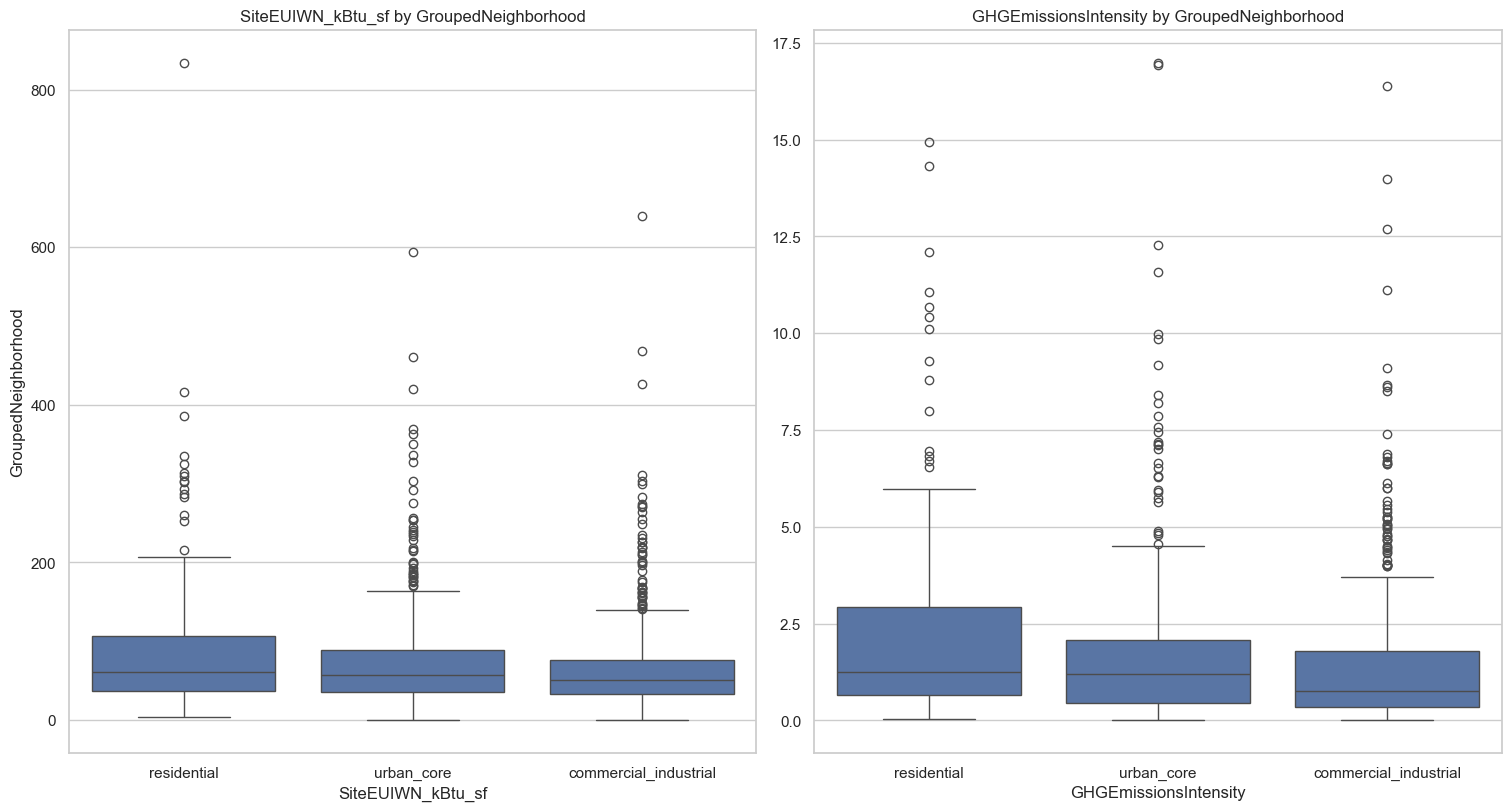

In [149]:
# 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
sns.set(style="whitegrid")

# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df.groupby('GroupedNeighborhood')['SiteEUIWN_kBtu_sf'].median().sort_values(ascending=False).index
# SiteEnergyUseWN(kBtu) boxplot
sns.boxplot(y='SiteEUIWN_kBtu_sf', x='GroupedNeighborhood', data=df, ax=axes[0], order=order_energy)
axes[0].set_title(f'SiteEUIWN_kBtu_sf by GroupedNeighborhood')
axes[0].set_xlabel('SiteEUIWN_kBtu_sf')
axes[0].set_ylabel('GroupedNeighborhood')

# Orderby median de  TotalGHGEmissions
order_ghg = df.groupby('GroupedNeighborhood')['GHGEmissionsIntensity'].median().sort_values(ascending=False).index
# TotalGHGEmissions boxplot
sns.boxplot(y='GHGEmissionsIntensity', x='GroupedNeighborhood', data=df, ax=axes[1], order=order_ghg)
axes[1].set_title(f'GHGEmissionsIntensity by GroupedNeighborhood')
axes[1].set_xlabel('GHGEmissionsIntensity')
axes[1].set_ylabel('')

#plt.tight_layout()
plt.show()

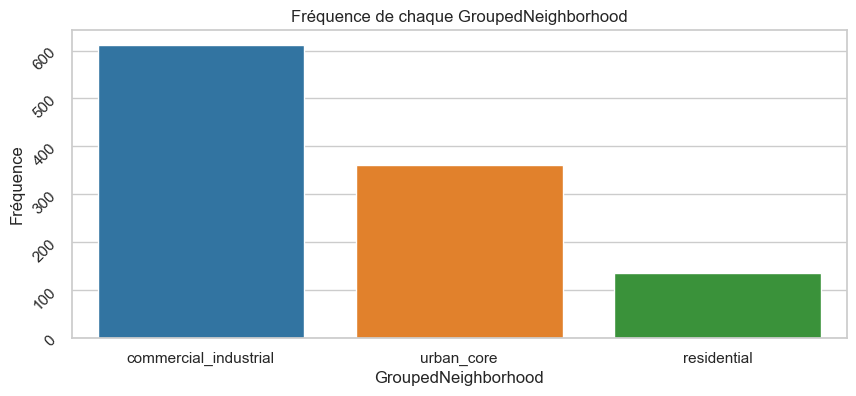

In [150]:
# Compter le nombre d'occurrences pour chaque GroupedNeighborhood
group_counts = df['GroupedNeighborhood'].value_counts().reset_index()
group_counts.columns = ['GroupedNeighborhood', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(x='GroupedNeighborhood', y='Counts', data=group_counts, hue='GroupedNeighborhood', palette="tab10", legend=False)

plt.yticks(rotation=45)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque GroupedNeighborhood')
plt.ylabel('Fréquence')
plt.xlabel('GroupedNeighborhood')

plt.show()

In [151]:
# Créez un tableau croisé des deux variables
cross_table = pd.crosstab(df['GroupedNeighborhood'], df['SiteEUIWN_kBtu_sf'])

# Effectuez le test du chi-carré
chi2, p, _, _ = chi2_contingency(cross_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

Chi-squared value: 1601.0028116393048
P-value: 0.02947265037433407


### PropertyUseType

LargestPropertyUseType, SecondLargestPropertyUseType et ThirdPropertyUseType ont trop de catégories. Nous allons essayer un regroupement logique.

In [152]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Other - Entertainment/Public Assembly', 'Library',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'College/University',
       'Automobile Dealership', 'K-12 School', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Care Community',
       'Medical Office', 'Retail Store', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other/Specialty Hospital',
       'Hospital (General Medical & Surgical)',
       'Non-Refrigerated Warehouse', 'Distribution Center',
       'Worship Facility', 'Restaurant', 'Data Center',
       'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
       'Laboratory', 'Strip Mall', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Lifestyle Center',
       'Other - Public Services', 'Financial Office', 'Fire Station',
       'Performing Arts', 'Other - Services', 'Other - Recreation',
       'Residential Care Facility', 'Bank Branch', 'Other - Education',
       'Othe

In [153]:
# Test avec un regroupement de catégories
def group_Type(type):
    # Très énergivore et Santé
    A = ['Data Center', 'Urgent Care/Clinic/Other Outpatient', 'Laboratory', 'Hospital', 'Other/Specialty Hospital', 'Hospital (General Medical & Surgical)']    
    # Public et culturel
    B = ['Museum', 'Other - Education', 'College/University', 'Adult Education', 'Other - Entertainment/Public Assembly',
         'Pre-school/Daycare', 'K-12 School', 'Social/Meeting Hall']   
    # Commerces, Restauration et loisirs
    C = ['Supermarket/Grocery Store', 'Lifestyle Center', 'Strip Mall', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 
         'Retail Store', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Automobile Dealership', 'Library', 'Other - Mall', 
         'Restaurant', 'Other - Recreation', 'Movie Theater', 'Fitness Center/Health Club/Gym', 'Performing Arts',
        'Other - Restaurant/Bar']
    # Résidences
    D = ['Senior Care Community', 'Residential Care Facility', 'Hotel']    
    # Industrie et entrepôts
    E = ['Manufacturing/Industrial Plant', 'Refrigerated Warehouse', 'Distribution Center', 'Non-Refrigerated Warehouse', 
         'Self-Storage Facility']
    # Bureaux et services
    F = ['Other - Public Services', 'Financial Office', 'Medical Office', 'Bank Branch', 'Office', 'Other - Utility',
        'Courthouse', 'Fire Station', 'Prison/Incarceration', 'Worship Facility', 'Other - Services']
    # Autres
    G = ['Other', 'Mixed Use Property']
 
    if type in A:
        return 'A - Data Center Sante'
    elif type in B:
        return 'B - Public et culturel'
    elif type in C:
        return 'C - Commerce resto loisirs'
    elif type in D:
        return 'D - Résidences'
    elif type in E:
        return 'E - Industrie et entrepots'
    elif type in F:
        return 'F - Bureaux et services'
    elif type in G:
        return 'G - Autres'
    else:
        return 'X - Non classifie'


df['GroupedLargType'] = df['LargestPropertyUseType'].apply(group_Type)

In [154]:
df_feat = df.copy()
df_feat['GFA_pct_EUI_Product'] = df_feat['LargestPropertyUseTypeGFA_pct'] * df_feat['SiteEUIWN_kBtu_sf']

In [155]:
perform_anova_tukey(df_feat, 'GFA_pct_EUI_Product', 'GroupedLargType')

ANOVA Table for GFA_pct_EUI_Product by GroupedLargType:
                          sum_sq      df          F        PR(>F)
C(GroupedLargType)  1.452382e+10     6.0  74.287519  6.714751e-78
Residual            3.590835e+10  1102.0        NaN           NaN



Tukey's HSD Results for GFA_pct_EUI_Product by GroupedLargType:
                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                          
          group1                     group2             meandiff  p-adj     lower       upper    reject
-------------------------------------------------------------------------------------------------------
     A - Data Center Sante     B - Public et culturel -21178.2818    0.0  -25370.091 -16986.4726   True
     A - Data Center Sante C - Commerce resto loisirs -16573.1742    0.0  -20654.262 -12492.0865   True
     A - Data Center Sante             D - Résidences -18949.3819    0.0 -23331.8785 -14566.8852   True
     A - Data Center Sante E - Industrie et entrepots -

In [156]:
df_feat['GFA_pct_GHG_Product'] = df_feat['LargestPropertyUseTypeGFA_pct'] * df_feat['GHGEmissionsIntensity']

In [157]:
perform_anova_tukey(df_feat, 'GFA_pct_GHG_Product', 'GroupedLargType')

ANOVA Table for GFA_pct_GHG_Product by GroupedLargType:
                          sum_sq      df          F        PR(>F)
C(GroupedLargType)  9.872424e+06     6.0  55.649937  3.877042e-60
Residual            3.258288e+07  1102.0        NaN           NaN



Tukey's HSD Results for GFA_pct_GHG_Product by GroupedLargType:
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
          group1                     group2            meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------------------------------
     A - Data Center Sante     B - Public et culturel -436.3179    0.0 -562.5874 -310.0484   True
     A - Data Center Sante C - Commerce resto loisirs -362.7024    0.0 -485.6367 -239.7682   True
     A - Data Center Sante             D - Résidences  -361.602    0.0 -493.6156 -229.5884   True
     A - Data Center Sante E - Industrie et entrepots    -542.2    0.0 -662.7519 -421.6482 

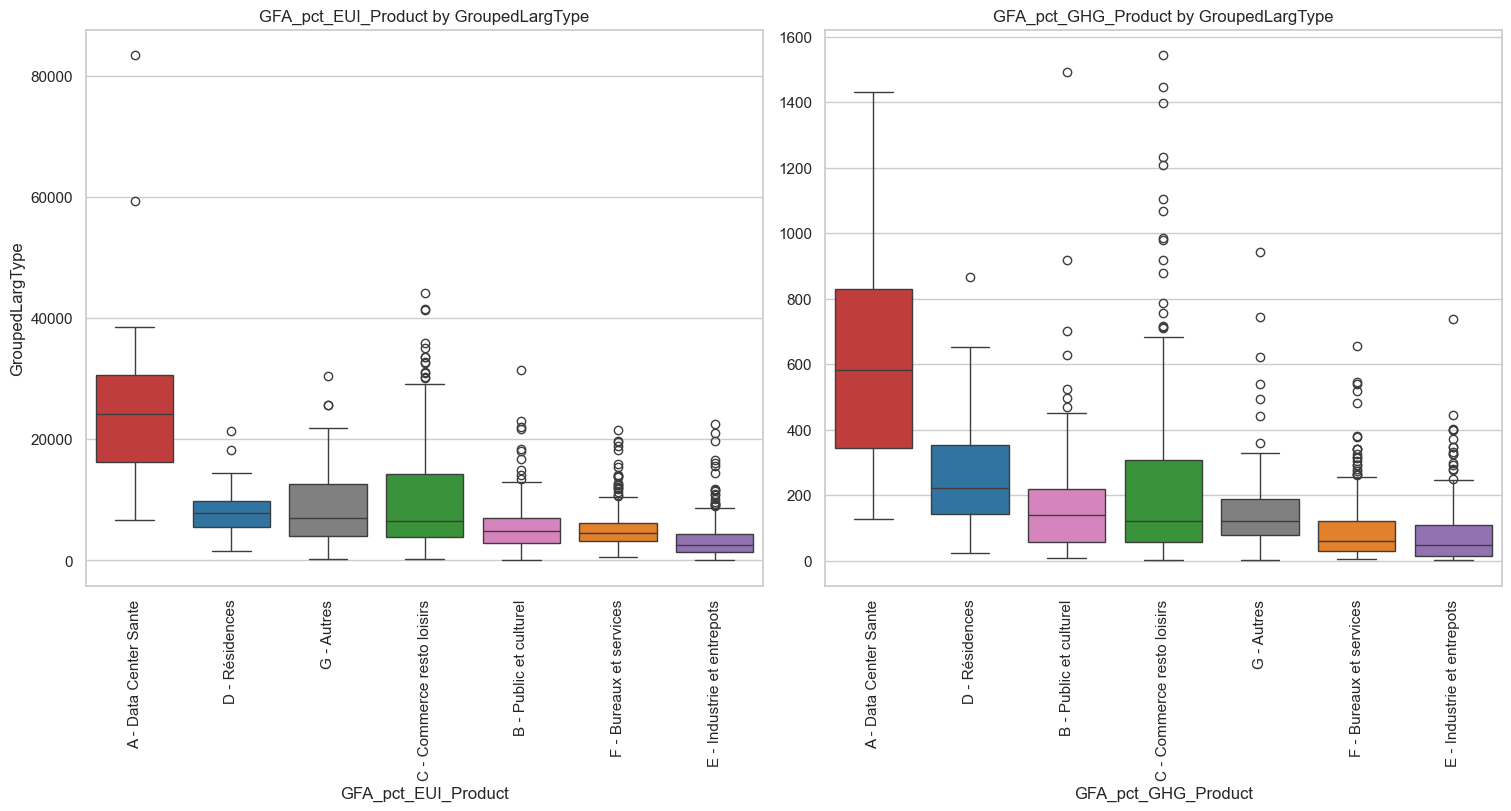

In [158]:
# Définir un dictionnaire de couleurs pour chaque catégorie
colors = {'A - Data Center Sante': '#d62728', 'B - Public et culturel': '#e377c2', 'C - Commerce resto loisirs': '#2ca02c', 
          'D - Résidences': '#1f77b4', 'E - Industrie et entrepots': '#9467bd', 'F - Bureaux et services': '#ff7f0e', 
          'G - Autres': 'grey'}

# 2 colonnes : SiteEnergyUseWN(kBtu) et TotalGHGEmissions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), constrained_layout=True)
sns.set(style="whitegrid")

# Orderby median de SiteEnergyUseWN(kBtu)
order_energy = df_feat.groupby('GroupedLargType')['GFA_pct_EUI_Product'].median().sort_values(ascending=False).index
# SiteEnergyUseWN(kBtu) boxplot
sns.boxplot(y='GFA_pct_EUI_Product', x='GroupedLargType', data=df_feat, ax=axes[0], order=order_energy, palette=colors, hue='GroupedLargType', legend=False)
axes[0].set_title(f'GFA_pct_EUI_Product by GroupedLargType')
axes[0].set_xlabel('GFA_pct_EUI_Product')
axes[0].set_ylabel('GroupedLargType')
axes[0].tick_params(axis='x', rotation=90) 


# Orderby median de  TotalGHGEmissions
order_ghg = df_feat.groupby('GroupedLargType')['GFA_pct_GHG_Product'].median().sort_values(ascending=False).index
# TotalGHGEmissions boxplot
sns.boxplot(y='GFA_pct_GHG_Product', x='GroupedLargType', data=df_feat, ax=axes[1], order=order_ghg, palette=colors, hue='GroupedLargType', legend=False)
axes[1].set_title(f'GFA_pct_GHG_Product by GroupedLargType')
axes[1].set_xlabel('GFA_pct_GHG_Product')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=90)  


#plt.tight_layout()
plt.show()

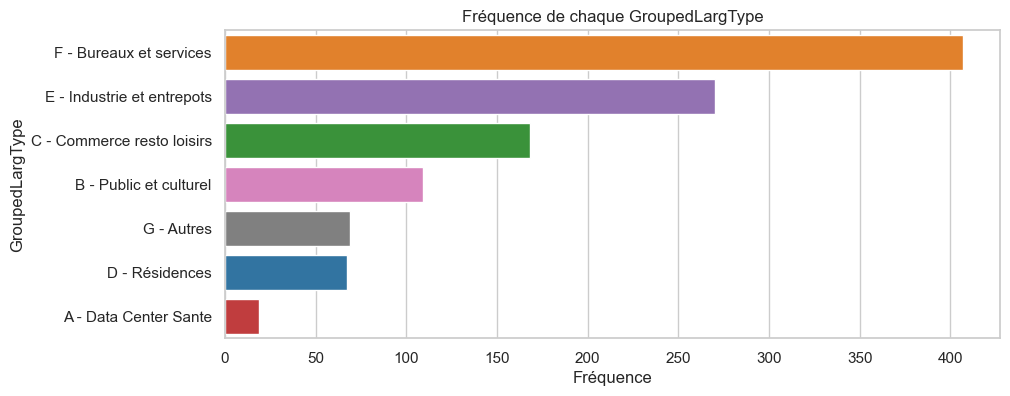

In [159]:
# Compter le nombre d'occurrences pour chaque GroupedPrimType
group_counts = df_feat['GroupedLargType'].value_counts().reset_index()
group_counts.columns = ['GroupedLargType', 'Counts']

plt.figure(figsize=(10, 4))

# Créer un graphique à barres
sns.barplot(y='GroupedLargType', x='Counts', data=group_counts, hue='GroupedLargType', palette=colors, legend=False)

# Ajouter des titres et des labels
plt.title('Fréquence de chaque GroupedLargType')
plt.xlabel('Fréquence')
plt.ylabel('GroupedLargType')

plt.show()

In [160]:
df_feat[df_feat['GroupedLargType'] == 'A - Data Center Sante'].shape[0]

19

In [161]:
# Créez un tableau croisé des deux variables
cross_table = pd.crosstab(df_feat['GroupedLargType'], df_feat['GFA_pct_EUI_Product'])

# Effectuez le test du chi-carré
chi2, p, _, _ = chi2_contingency(cross_table)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")


Chi-squared value: 6014.369092699607
P-value: 0.028800869115811586


In [162]:
df_feat['LargestPropertyUseType'].unique()

array(['Hotel', 'Other - Entertainment/Public Assembly', 'Library',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'College/University',
       'Automobile Dealership', 'K-12 School', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Care Community',
       'Medical Office', 'Retail Store', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other/Specialty Hospital',
       'Hospital (General Medical & Surgical)',
       'Non-Refrigerated Warehouse', 'Distribution Center',
       'Worship Facility', 'Restaurant', 'Data Center',
       'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient',
       'Laboratory', 'Strip Mall', 'Refrigerated Warehouse',
       'Manufacturing/Industrial Plant', 'Lifestyle Center',
       'Other - Public Services', 'Financial Office', 'Fire Station',
       'Performing Arts', 'Other - Services', 'Other - Recreation',
       'Residential Care Facility', 'Bank Branch', 'Other - Education',
       'Othe

In [163]:
df_feat['SecondLargestPropertyUseType'].unique()

array(['None', 'Restaurant', 'Data Center', 'K-12 School',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Swimming Pool', 'Other - Entertainment/Public Assembly', 'Office',
       'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Food Service', 'Laboratory', 'Medical Office',
       'Other - Recreation', 'Convenience Store without Gas Station',
       'Pre-school/Daycare', 'Financial Office', 'Other - Restaurant/Bar',
       'College/University', 'Supermarket/Grocery Store',
       'Adult Education', 'Multifamily Housing', 'Bar/Nightclub',
       'Performing Arts', 'Other - Technology/Science',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Manufacturing/Industrial Plant', 'Other - Lodging/Residential',
       'Bank Branch', 'Refrigerated Warehouse',
       'Fi

In [164]:
# Trouver les éléments uniques dans second_largest qui ne sont pas dans largest
second_set = set(df_feat['SecondLargestPropertyUseType'].unique())
largest_set = set(df_feat['LargestPropertyUseType'].unique())

unique_in_second_not_in_largest = second_set - largest_set

unique_in_second_not_in_largest

{'Bar/Nightclub',
 'Convenience Store without Gas Station',
 'Food Sales',
 'Food Service',
 'Multifamily Housing',
 'None',
 'Other - Lodging/Residential',
 'Other - Technology/Science',
 'Residence Hall/Dormitory',
 'Swimming Pool',
 'Vocational School'}

In [165]:
# Mappage des catégories SecondLargestPropertyUseType vers les catégories existantes de LargestPropertyUseType
mapping = {
    'Bar/Nightclub': 'Other - Entertainment/Public Assembly',
    'Convenience Store without Gas Station': 'Retail Store',
    'Food Sales': 'Restaurant',
    'Food Service': 'Restaurant',
    'Other - Lodging/Residential': 'Hotel',
    'Other - Technology/Science': 'Office', 
    'Residence Hall/Dormitory': 'College/University',
    'Vocational School': 'Other - Education',
    'Swimming Pool': 'Other - Recreation',
    'Multifamily Housing': 'Hotel'
}

# Application du mappage
df_feat['SecondLargestPropertyUseType'] = df_feat['SecondLargestPropertyUseType'].map(mapping).fillna(df_feat['SecondLargestPropertyUseType'])


In [167]:
df_feat['GroupedSecondLargType'] = df_feat['SecondLargestPropertyUseType'].apply(group_Type)

In [168]:
# Trouver les éléments uniques dans thirdlargest qui ne sont pas dans largest
third_set = set(df_feat['ThirdLargestPropertyUseType'].unique())
largest_set = set(df_feat['LargestPropertyUseType'].unique())

unique_in_third_not_in_largest = third_set - largest_set

unique_in_third_not_in_largest

{'Fast Food Restaurant', 'Food Service', 'Multifamily Housing', 'None'}

In [169]:
# Mappage des catégories ThirdLargestPropertyUseType vers les catégories existantes de LargestPropertyUseType
mapping = {
    'Fast Food Restaurant': 'Restaurant',
    'Food Service': 'Restaurant',
    'Multifamily Housing': 'Hotel'
}

# Application du mappage
df_feat['ThirdLargestPropertyUseType'] = df_feat['ThirdLargestPropertyUseType'].map(mapping).fillna(df_feat['ThirdLargestPropertyUseType'])


In [170]:
df_feat['GroupedThirdLargType'] = df_feat['ThirdLargestPropertyUseType'].apply(group_Type)

# Export des données

In [171]:
df_featured = df_feat[['TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)', 'Log_TotalGHGEmissions', 'Log_SiteEnergyUseWN', 'NumberofBuildings', 
                       'NumberofFloors', 'BuildingType', 'NumberOfPropertyUseTypes','PropertyGFATotal', 
                       'LargestPropertyUseTypeGFA_pct', 'SecondLargestPropertyUseTypeGFA_pct', 'ThirdLargestPropertyUseTypeGFA_pct', 
                       'PropertyGFAParking_pct', 'BuildingAge', 'GroupedNeighborhood', 
                       'GroupedLargType', 'GroupedSecondLargType', 'GroupedThirdLargType', 'SteamUse_pct', 'Electricity_pct', 
                       'NaturalGas_pct', 'ENERGYSTARScore']]
df_featured.head(2)

TotalGHGEmissions  SiteEnergyUseWN(kBtu)  Log_TotalGHGEmissions  \
0             249.98              7456910.0               5.521381   
1             295.86              8664479.0               5.689886   

   Log_SiteEnergyUseWN  NumberofBuildings  NumberofFloors    BuildingType  \
0            15.824652                1.0              12  NonResidential   
1            15.974742                1.0              11  NonResidential   

   NumberOfPropertyUseTypes  PropertyGFATotal  LargestPropertyUseTypeGFA_pct  \
0                         1             88434                     100.000000   
1                         3            103566                      80.991831   

   SecondLargestPropertyUseTypeGFA_pct  ThirdLargestPropertyUseTypeGFA_pct  \
0                             0.000000                                 0.0   
1                             4.462855                                 0.0   

   PropertyGFAParking_pct  BuildingAge    GroupedNeighborhood GroupedLargType  \
0                0.000000           89  commercial_industrial  D - Résidences   
1               14.545314           20  commercial_industrial  D - Résidences   

        GroupedSecondLargType GroupedThirdLargType  SteamUse_pct  \
0           X - Non classifie    X - Non classifie      26.87282   
1  C - Commerce resto loisirs    X - Non classifie       0.00000   

   Electricity_pct  NaturalGas_pct  ENERGYSTARScore  
0        52.917723        17.11772             60.0  
1        37.426959        59.38132             61.0

In [172]:
df_featured.shape

(1109, 22)

In [173]:
path     = "data/cleaned/"
filename = "df_cleaned.csv"

In [174]:
df_featured.to_csv(path+filename, index=False)

In [175]:
# Normalisation des données
scaler = StandardScaler()

df_normalized = df_featured.copy()

# Sélectionner uniquement les colonnes numériques
numerics_col = df_featured.select_dtypes(include=['number']).columns

# Appliquez la normalisation min-max aux données
df_normalized[numerics_col] = scaler.fit_transform(df_featured[numerics_col])

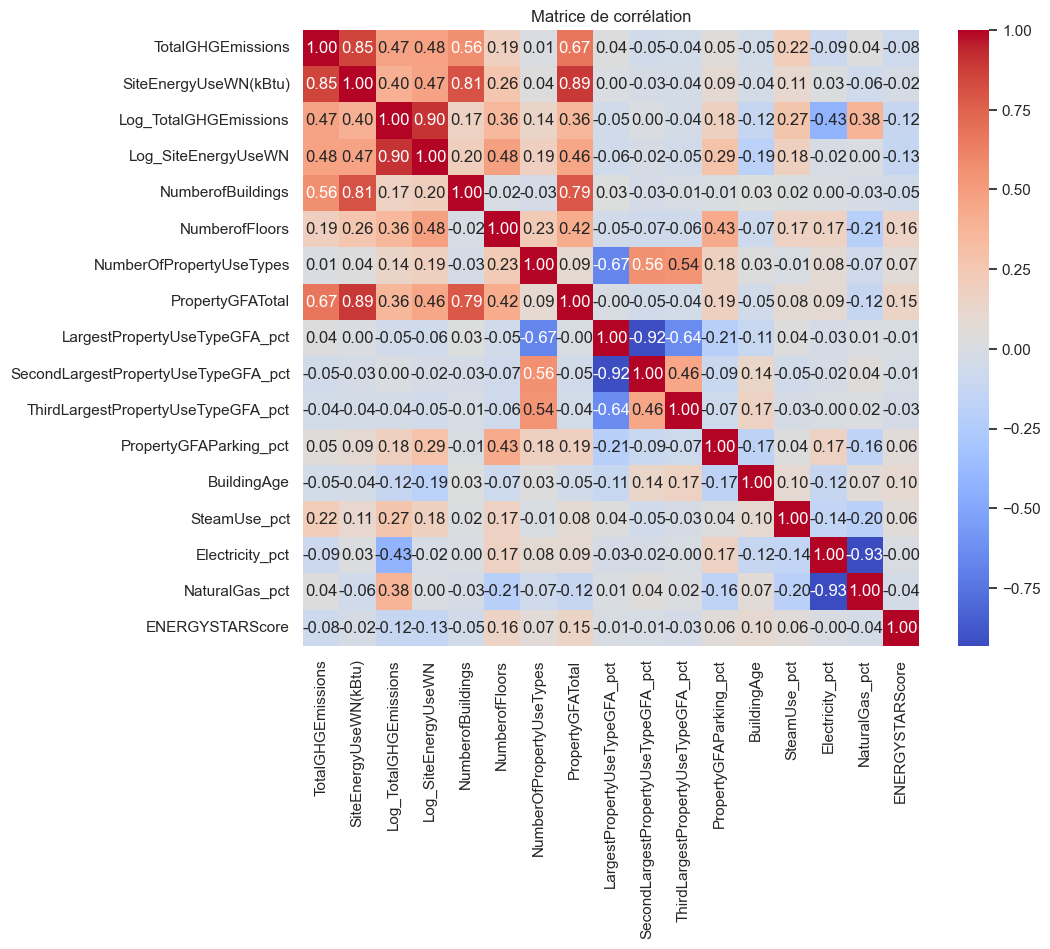

In [176]:
# Calcul de la matrice de corrélation
corr_matrix = df_normalized[numerics_col].corr()

# Création d'une heatmap avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

# Titre et affichage du graphique
plt.title('Matrice de corrélation')
plt.show()